In [ ]:
import pandas as pd
df=pd.read_csv('thermo_data_cleaned.csv')

In [ ]:
keep_cols = [
    "doi_key",
    "name",
    "ZT_values",
    "electrical_conductivity",
    "electrical_resistivity",
    "seebeck_coefficient",
    "power_factor",
    "thermal_conductivity",
    "compound_type",
    "crystal_structure",
    "lattice_structure",
    "space_group",
    "processing_method",
    "material_name",
    "doping.doping_type",
    "doping.dopants"
]

df = df[keep_cols]

In [ ]:
df["doi_key"] = df["doi_key"].str.replace(
    r"^(10\.\d{4})([a-zA-Z])",  # Pattern: 10.XXXX followed by a letter
    r"\1/\2",  # Insert / between prefix and letter
    regex=True
)
import ast

def clean_column(col):
    def clean_entry(entry):
        try:
            data = ast.literal_eval(entry) if isinstance(entry, str) else entry
            if isinstance(data, list) and all(
                isinstance(d, dict) and next(iter(d.values()), None) is None for d in data
            ):
                return []
            return data
        except Exception:
            return entry
    return col.apply(clean_entry)

cols_to_clean = [
    'ZT_values',
    'electrical_conductivity',
    'electrical_resistivity',
    'seebeck_coefficient',
    'power_factor',
    'thermal_conductivity'
]

for col in cols_to_clean:
    df[col] = clean_column(df[col])


import numpy as np

def empty_or_none_to_nan(col):
    def convert(entry):
        # If entry is an empty list or a list of only None, return np.nan
        if isinstance(entry, list):
            if len(entry) == 0 or all(e is None for e in entry):
                return np.nan
        return entry
    return col.apply(convert)

for col_name in cols_to_clean:
    df[col_name] = empty_or_none_to_nan(df[col_name])


df = df.dropna(subset=cols_to_clean, how='all').reset_index(drop=True)


In [ ]:
# === Replace [] with NaN in doping.dopants ===
df["doping.dopants"] = df["doping.dopants"].apply(
    lambda x: np.nan if str(x).strip() in ["[]", "nan", "NaN"] else x
)

In [ ]:
import re

# Define mapping rules
def normalize_doping_type(val: str) -> str:
    if not isinstance(val, str):
        return val

    s = val.strip().lower()

    # --- n-type group ---
    if re.fullmatch(r"(n[- ]?type|n|n-type,?doping|n-doping)", s, flags=re.I):
        return "n-type"

    # --- p-type group ---
    if re.fullmatch(r"(p[- ]?type|p|p-type,?doping|p-doping)", s, flags=re.I):
        return "p-type"

    # --- combined n+p group ---
    if re.search(r"n.*p[- ]?type|p.*n[- ]?type", s):
        return "n+p-type"

    return val  # leave others unchanged

# Apply normalization
df["doping.doping_type"] = df["doping.doping_type"].map(normalize_doping_type)

def normalize_crystal_structure(s: str) -> str:
    if not isinstance(s, str):
        return s
    x = s.strip()
    xl = x.lower()

    # ----- Simple family-level merges -----
    # FCC family
    if re.search(r"\bfcc\b|face[- ]?centred|face[- ]?centered", xl):
        return "fcc"
    # BCC family
    if re.search(r"\bbcc\b|body[- ]?centered cubic", xl):
        return "bcc"
    # Rock-salt family (NaCl)
    if re.search(r"rock[- ]?salt|rocksalt|nacl(-type)?|cubic rock[- ]?salt|cubic rock[- ]?salt", xl):
        return "rock-salt"
    # Anti-fluorite
    if re.search(r"anti[- ]?fluorite|antifluorite|cubic anti[- ]?fluorite", xl):
        return "anti-fluorite"
    # Fluorite
    if re.search(r"\bfluorite\b", xl):
        return "fluorite"
    # Zinc blende (sphalerite)
    if re.search(r"zinc[- ]?blende|cubic zinc blende", xl):
        return "zinc blende (sphalerite)"
    # Wurtzite
    if re.search(r"wurtzite", xl):
        return "wurtzite"
    # Perovskite
    if re.search(r"perovskite", xl):
        # keep subtypes but collapse to perovskite family
        return "perovskite"
    # Heusler / half-Heusler
    if re.search(r"\bhalf[- ]?heusler\b|\bc1b\b|mgagas[- ]?type|cubic mgagas[- ]?type", xl):
        return "half-Heusler (C1b)"
    if re.search(r"\bl21\b|\bheusler\b", xl):
        return "Heusler (L21)"
    # Clathrates
    if re.search(r"type[- ]?i+.*clathrate|type[- ]?v?iii", xl):
        # group all clathrate types
        return "clathrate"
    # Skutterudite
    if re.search(r"skutterudite", xl):
        return "skutterudite"
    # Tetradymite
    if re.search(r"tetradymite", xl):
        return "tetradymite"
    # Chalcopyrite / Kesterite / Stannite
    if re.search(r"chalcopyrite", xl):
        return "chalcopyrite"
    if re.search(r"kesterite", xl):
        return "kesterite"
    if re.search(r"stannite", xl):
        return "stannite"
    # Delafossite / Spinel / Pyrochlore
    if re.search(r"delafossite", xl):
        return "delafossite"
    if re.search(r"spinel", xl):
        return "spinel"
    if re.search(r"pyrochlore", xl):
        return "pyrochlore"
    # Tetrahedrite
    if re.search(r"tetrahedrite", xl):
        return "tetrahedrite"
    # Nowotny chimney-ladder
    if re.search(r"nowotny.*chimney[- ]ladder", xl):
        return "Nowotny chimney-ladder"
    # CaAl2Si2 family
    if re.search(r"caa[l1]2si2(-type)?|α[- ]?mg3sb2|mg3sb2", xl):
        return "CaAl2Si2-type"
    # ZrCuSiAs family (aka 1111)
    if re.search(r"zrcusias|zrsicuas|zrcusias[- ]?type", xl):
        return "ZrCuSiAs-type (1111)"
    # Misfit layered
    if re.search(r"\bmisfit[- ]?layered\b|\bmisfit layered\b|\bmisfit\b", xl):
        return "misfit-layered"
    # Layered
    if re.search(r"\blayered\b|monolayer", xl):
        return "layered"
    # Honeycomb
    if re.search(r"honeycomb", xl):
        return "honeycomb"
    # Superlattice
    if re.search(r"superlattice", xl):
        return "superlattice"
    # Graphitic / diamond
    if re.search(r"graphitic", xl):
        return "graphitic"
    if re.search(r"\bdiamond\b", xl):
        return "diamond"
    # Rutile / Anatase / Tungsten bronze
    if re.search(r"rutile", xl):
        return "rutile"
    if re.search(r"anatase", xl):
        return "anatase"
    if re.search(r"tungsten bronze", xl):
        return "tungsten bronze"
    # CdI2 polytypes
    if re.search(r"\b1t(-cdi2)?\b|\b2h\b", xl):
        return "CdI2 polytype"
    # Spinel (cubic spinel)
    if re.search(r"cubic spinel", xl):
        return "spinel"
    # Rock-salt (explicit cubic prefix handled above; fallback)
    if re.fullmatch(r"nacl", xl):
        return "rock-salt"
    # Crystalline descriptors collapse
    if re.fullmatch(r"single crystal|single crystalline", xl):
        return "single crystal"
    if re.fullmatch(r"polycrystalline|nanocrystalline|nanostructured|semi-crystalline|crystalline|crystal|single phase", xl):
        return "microstructure"
    # Generic symmetry systems
    if re.fullmatch(r"cubic", xl):
        return "cubic"
    if re.fullmatch(r"tetragonal", xl):
        return "tetragonal"
    if re.fullmatch(r"orthorhombic", xl):
        return "orthorhombic"
    if re.fullmatch(r"rhombohedral|trigonal|rhombohedral/cubic", xl):
        return "rhombohedral"
    if re.fullmatch(r"hexagonal", xl):
        return "hexagonal"
    if re.fullmatch(r"monoclinic|monoclinic/cubic", xl):
        return "monoclinic"
    if re.fullmatch(r"triclinic", xl):
        return "triclinic"
    if re.fullmatch(r"amorphous", xl):
        return "amorphous"
    # Space groups or symbols (leave as-is or map to cubic system)
    if re.search(r"\bpm3", xl):
        return "cubic"
    # Fallback: return original cleaned string (retain informative specifics)
    return x

df["crystal_structure"] = df["crystal_structure"].astype(str).map(normalize_crystal_structure)
df["crystal_structure"].replace("nan", pd.NA, inplace=True)

def normalize_compound_type(s: str) -> str:
    if not isinstance(s, str):
        return s
    x = s.strip()
    xl = x.lower()

    # Heusler family
    if re.search(r"half[- ]?heusler", xl):
        return "half-Heusler"
    if re.search(r"heusler", xl):
        return "Heusler"

    # Zintl family
    if "zintl" in xl:
        return "Zintl"

    # Perovskite family
    if "perovskite" in xl:
        return "perovskite"

    # Chalcogenides
    if re.search(r"chalcogenide|selenide|telluride|dichalcogenide|tmdc", xl):
        return "chalcogenide"
    if "sulfide" in xl:
        return "sulfide"

    # Carbon family
    if re.search(r"graphene|nanotube|nanoribbon|nanowire|carbon", xl):
        return "carbon-based"

    # Polycrystal / film / bulk
    if re.search(r"polycrystal|single crystal|crystal", xl):
        return "crystalline"
    if "film" in xl:
        return "film"
    if "bulk" in xl:
        return "bulk"

    # Alloys
    if "alloy" in xl:
        return "alloy"

    # Polymers / organic
    if "polymer" in xl:
        return "polymer"
    if "organic" in xl:
        return "organic"
    if "ionogel" in xl or "mof" in xl:
        return "organic/inorganic hybrid"

    # Oxides & anion groups
    if "oxide" in xl:
        return "oxide"
    if "boride" in xl:
        return "boride"
    if "carbide" in xl:
        return "carbide"
    if "nitride" in xl:
        return "nitride"
    if "silicide" in xl:
        return "silicide"

    # Structure prototypes (keep as-is)
    if any(word in xl for word in ["spinel","chalcopyrite","tetrahedrite","skutterudite","argyrodite","colusite","cobaltite"]):
        return x

    # Others
    if "mxene" in xl:
        return "MXene"
    if "2d" in xl or "monolayer" in xl:
        return "2D material"
    if "heterostructure" in xl or "superlattice" in xl or "complex" in xl:
        return "heterostructure"
    if "semiconduct" in xl:
        return "semiconductor"
    if "semimetal" in xl:
        return "semimetal"
    if "ceramic" in xl:
        return "ceramic"
    if "glass" in xl:
        return "glass"

    return x

df["compound_type"] = df["compound_type"].map(normalize_compound_type)


/tmp/ipython-input-3690852501.py:162: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["crystal_structure"].replace("nan", pd.NA, inplace=True)


In [ ]:
df['doping.doping_type'].value_counts().to_csv('doping_type_counts.csv')

In [ ]:
 df["crystal_structure"].dropna().value_counts()


,count
crystal_structure,
cubic,2116
rhombohedral,1326
orthorhombic,1113
rock-salt,787
layered,662
...,...
CaF2-type,1
nanocrystalline tetragonal,1
hexagonal dominant with orthorhombic polymorphic form,1


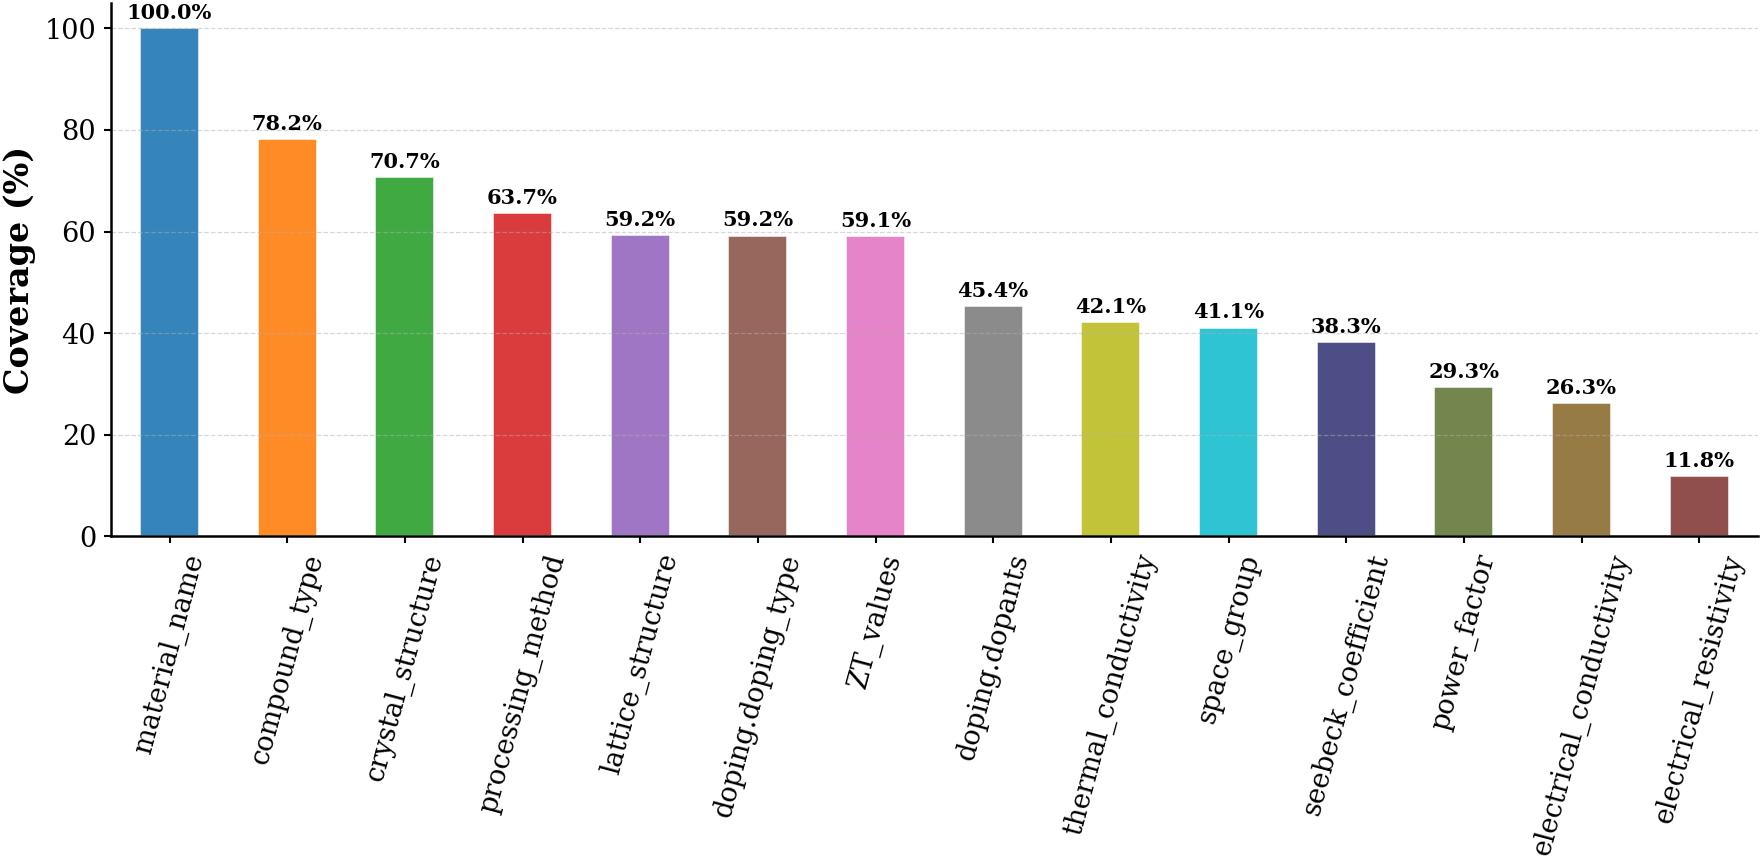

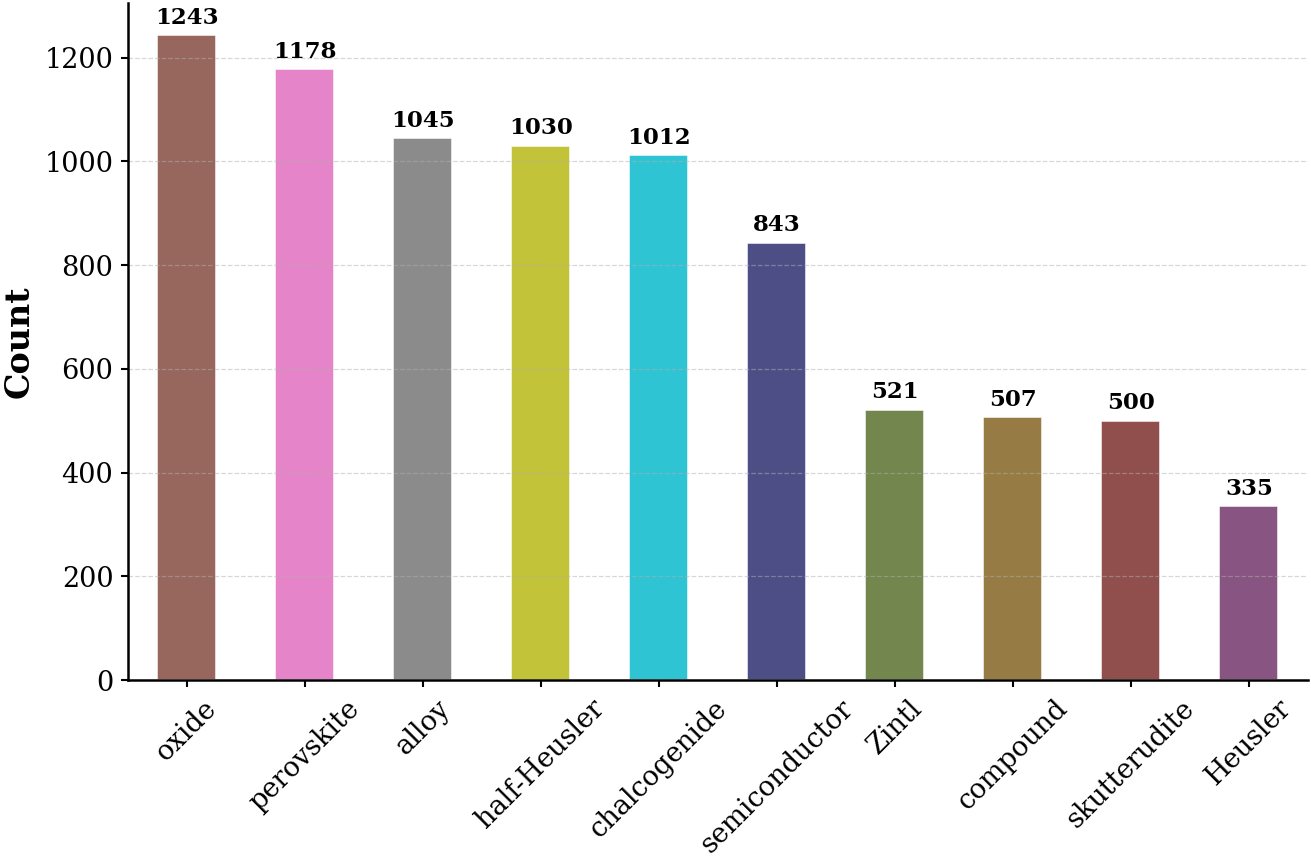

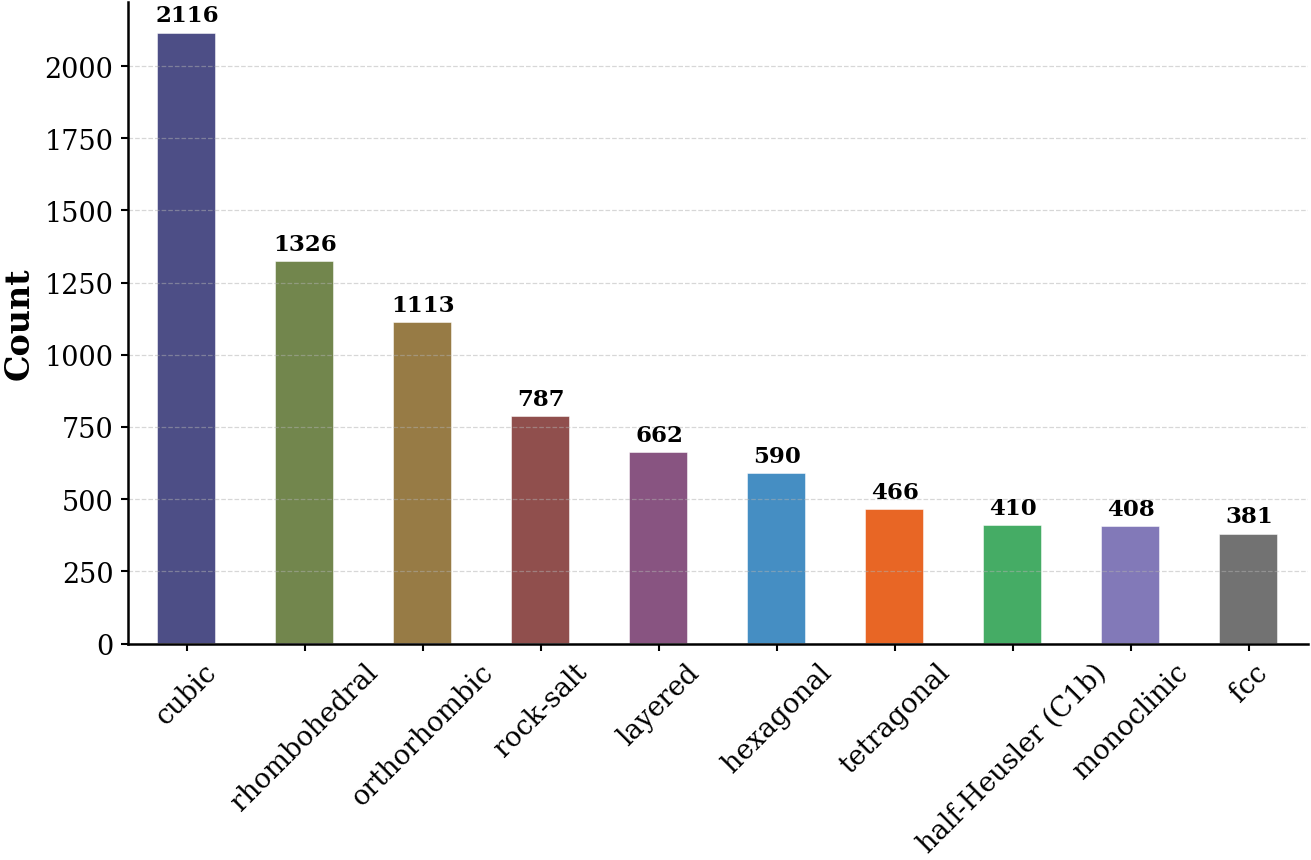

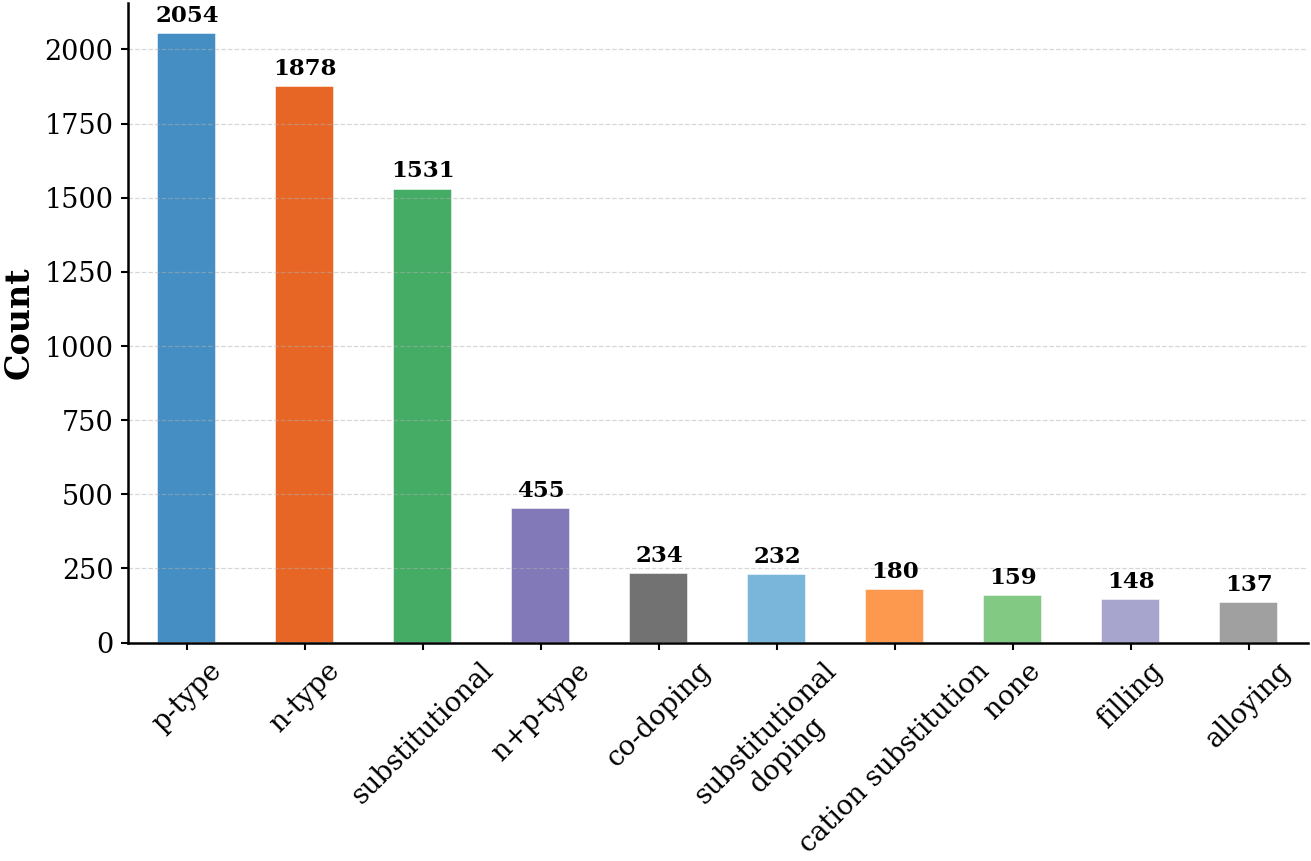

✅ Saved journal-quality figures to /content: PNG (600 dpi) + PDF


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import textwrap
import os
import numpy as np


# =========================
rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times", "Computer Modern Roman"],
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 14,
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.02,
    "figure.dpi": 150,
    "axes.unicode_minus": False,
})

# Journal-quality color palette (professional, distinct, colorblind-friendly)
JOURNAL_PALETTE = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",  # Classic matplotlib
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",  # Scientific colors
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173",  # Nature-style colors
    "#3182bd", "#e6550d", "#31a354", "#756bb1", "#636363",  # Brewer qualitative
    "#6baed6", "#fd8d3c", "#74c476", "#9e9ac8", "#969696"   # Lighter variants
]

def _beautify_axes(ax):
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    for side in ["left", "bottom"]:
        ax.spines[side].set_linewidth(1.2)
    ax.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
    ax.grid(False, axis="x")

def _wrap_xticklabels(ax, width=18):
    labels = []
    for label in ax.get_xticklabels():
        txt = label.get_text()
        labels.append("\n".join(textwrap.wrap(txt, width=width)))
    ax.set_xticklabels(labels)

def _save(fig, stem, dpi=1200, outdir="/content"):
    os.makedirs(outdir, exist_ok=True)
    fig.savefig(os.path.join(outdir, f"{stem}.png"), dpi=dpi, bbox_inches="tight")
    fig.savefig(os.path.join(outdir, f"{stem}.pdf"), bbox_inches="tight")

def _safe_drop(df, drop_cols):
    exist = [c for c in drop_cols if c in df.columns]
    return df.drop(columns=exist) if exist else df

def _get_journal_colors(n_bars, plot_index):
    """Get professional colors for journal publications"""
    # Use a consistent but varied color scheme across plots
    start_index = (plot_index * 5) % len(JOURNAL_PALETTE)
    colors = []
    for i in range(n_bars):
        color_index = (start_index + i) % len(JOURNAL_PALETTE)
        colors.append(JOURNAL_PALETTE[color_index])
    return colors

# =========================
# 1) Data Coverage by Field (%)
# =========================
drop_cols = ["doi_key", "name"]
coverage_percent = (
    _safe_drop(df, drop_cols)
    .notnull()
    .sum()
    .div(len(df))
    .mul(100)
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(12, 6))
colors = _get_journal_colors(len(coverage_percent), 0)
bars = coverage_percent.plot(kind="bar", color=colors, edgecolor="white", linewidth=0.8, ax=ax, alpha=0.9)
ax.set_ylabel("Coverage (%)", fontweight='bold')
ax.set_xlabel("")
ax.tick_params(axis='x', rotation=75)
_wrap_xticklabels(ax, width=28)
_beautify_axes(ax)

# Add value labels on top of bars
for i, (idx, val) in enumerate(coverage_percent.items()):
    ax.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
_save(fig, "coverage_by_field", dpi=600)
plt.show()

# =========================
# 2) Top Compound Types
# =========================
if "compound_type" in df.columns:
    compound_counts = df["compound_type"].dropna().value_counts().head(10)

    fig, ax = plt.subplots(figsize=(9, 6))
    colors = _get_journal_colors(len(compound_counts), 1)
    bars = compound_counts.plot(kind="bar", color=colors, edgecolor="white", linewidth=0.8, ax=ax, alpha=0.9)
    ax.set_ylabel("Count", fontweight='bold')
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    _wrap_xticklabels(ax, width=20)
    _beautify_axes(ax)

    # Add value labels on top of bars
    for i, (idx, val) in enumerate(compound_counts.items()):
        ax.text(i, val + max(compound_counts)*0.01, f'{val}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    _save(fig, "top_compound_types", dpi=600)
    plt.show()
else:
    print("⚠️ Column 'compound_type' not found; skipping Top Compound Types plot.")

# =========================
# 3) Top Crystal Structures
# =========================
if "crystal_structure" in df.columns:
    crystal_counts = df["crystal_structure"].dropna().value_counts().head(10)

    fig, ax = plt.subplots(figsize=(9, 6))
    colors = _get_journal_colors(len(crystal_counts), 2)
    bars = crystal_counts.plot(kind="bar", color=colors, edgecolor="white", linewidth=0.8, ax=ax, alpha=0.9)
    ax.set_ylabel("Count", fontweight='bold')
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    _wrap_xticklabels(ax, width=20)
    _beautify_axes(ax)

    # Add value labels on top of bars
    for i, (idx, val) in enumerate(crystal_counts.items()):
        ax.text(i, val + max(crystal_counts)*0.01, f'{val}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    _save(fig, "top_crystal_structures", dpi=600)
    plt.show()
else:
    print("⚠️ Column 'crystal_structure' not found; skipping Top Crystal Structures plot.")

# =========================
# 4) Top Doping Types
# =========================
dop_col = "doping.doping_type"
if dop_col in df.columns:
    doping_counts = df[dop_col].dropna().value_counts().head(10)

    fig, ax = plt.subplots(figsize=(9, 6))
    colors = _get_journal_colors(len(doping_counts), 3)
    bars = doping_counts.plot(kind="bar", color=colors, edgecolor="white", linewidth=0.8, ax=ax, alpha=0.9)
    ax.set_ylabel("Count", fontweight='bold')
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    _wrap_xticklabels(ax, width=20)
    _beautify_axes(ax)

    # Add value labels on top of bars
    for i, (idx, val) in enumerate(doping_counts.items()):
        ax.text(i, val + max(doping_counts)*0.01, f'{val}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    _save(fig, "top_doping_types", dpi=600)
    plt.show()
else:
    print(f"⚠️ Column '{dop_col}' not found; skipping Top Doping Types plot.")

print("✅ Saved journal-quality figures to /content: PNG (600 dpi) + PDF")

In [ ]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
from typing import Any, Dict, Iterable, List, Optional, Tuple
# ---- Property specs: where values/units live + target units ----
PROP_SPECS = {
    "zt_values": {
        "col": "ZT_values",
        "value_keys": ["value", "ZT_value"],
        "unit_keys": ["unit", "ZT_unit", "Unit"],  # ZT is dimensionless
        "target_unit": ""  # dimensionless
    },
    "seebeck_coefficient": {
        "col": "seebeck_coefficient",
        "value_keys": ["S_value", "value"],
        "unit_keys": ["S_unit", "unit", "Unit"],
        "target_unit": "μV/K"
    },
    "electrical_conductivity": {
        "col": "electrical_conductivity",
        "value_keys": ["σ_value", "sigma_value", "value"],
        "unit_keys": ["σ_unit", "sigma_unit", "unit", "Unit"],
        "target_unit": "S/m"
    },
    "electrical_resistivity": {
        "col": "electrical_resistivity",
        "value_keys": ["ρ_value", "rho_value", "value"],
        "unit_keys": ["ρ_unit", "rho_unit", "unit", "Unit"],
        "target_unit": "Ω·m"
    },
    "power_factor": {
        "col": "power_factor",
        "value_keys": ["PF_value", "value"],
        "unit_keys": ["PF_unit", "unit", "Unit"],
        "target_unit": "W/mK²"
    },
    "thermal_conductivity": {
        "col": "thermal_conductivity",
        "value_keys": ["κ_value", "k_value", "value"],
        "unit_keys": ["κ_unit", "k_unit", "unit", "Unit"],
        "target_unit": "W/mK"
    },
}

# ---- Bins (in canonical units) & pretty titles ----
BINS = {
    "zt_values": np.linspace(0, 6, 50),                 # ZT
    "seebeck_coefficient": np.linspace(-1000, 1000, 50),# μV/K
    "electrical_conductivity": np.logspace(-2, 6, 50),  # S/m
    "electrical_resistivity": np.logspace(-8, 4, 50),   # Ω·m
    "power_factor": np.logspace(-6, 6, 50),             # W/mK^2
    "thermal_conductivity": np.linspace(0, 10, 50),     # W/mK
}

# Correct the TITLES dictionary
TITLES = {
    "zt_values": r"$ZT$",
    "seebeck_coefficient": r"$S$ ($\mu$V/K)",
    "electrical_conductivity": r"$\sigma$ (S/m)",
    "electrical_resistivity": r"$\rho$ ($\Omega$·m)",
    "power_factor": r"$PF$ (W/mK$^2$)",
    "thermal_conductivity": r"$\kappa$ (W/mK)",
}
# ---- Parsing & unit normalization helpers ----

def parse_obj(cell: Any) -> Optional[Iterable]:
    """Parse a cell that may be JSON-like text (list/dict); return list/dict or None."""
    if cell is None or (isinstance(cell, float) and np.isnan(cell)):
        return None
    if isinstance(cell, (list, dict)):
        return cell
    s = str(cell).strip()
    if s in ("", "None", "nan", "[]", "{}", "NaN"):
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def clean_unit(u: Any) -> str:
    """Normalize common unit variants to a simple comparable string."""
    if u is None:
        return ""
    s = str(u).strip()
    s = s.replace("µ", "μ")
    # be a little liberal converting 'u' to micro when used with V/W symbols
    s = re.sub(r'(^|[^A-Za-z])u(V|W)', r'\1μ\2', s)
    s = s.replace(" ", "").replace("·", "").replace("*", "")
    s = s.replace("cm-1","cm^-1").replace("m-1","m^-1")
    s = s.replace("Ω-1","Ω^-1").replace("ohm","Ω").replace("Ohm","Ω")
    return s.lower()

def normalize_value(prop: str, val: Any, unit_raw: Any) -> Tuple[Optional[float], str]:
    """
    Convert (value, unit_raw) to canonical unit for this property.
    Returns (value_in_target_unit, target_unit). If unit unknown, assume it's already canonical.
    """
    target = PROP_SPECS[prop]["target_unit"]

    # ZT (dimensionless)
    if prop == "zt_values":
        try:
            return float(val), target
        except Exception:
            return None, target

    u = clean_unit(unit_raw) if unit_raw not in (None, "", "None", "nan") else ""

    try:
        v = float(val)
    except Exception:
        return None, target

    # Seebeck -> μV/K
    if prop == "seebeck_coefficient":
        if u in ("μv/k","μvk","microv/k","microvk","μvperk"):
            factor = 1.0
        elif u in ("mv/k","mvk"):
            factor = 1e3
        elif u in ("v/k","vk"):
            factor = 1e6
        else:
            factor = 1.0
        return v * factor, target

    # Conductivity -> S/m
    if prop == "electrical_conductivity":
        if u in ("s/m","sm-1"):
            factor = 1.0
        elif u in ("s/cm","scm-1","Ω^-1cm^-1","ω^-1cm^-1","ohm^-1cm^-1"):
            factor = 100.0
        else:
            factor = 1.0
        return v * factor, target

    # Resistivity -> Ω·m
    if prop == "electrical_resistivity":
        if u in ("Ωm","ωm","ohmm"):
            factor = 1.0
        elif u in ("Ωcm","ωcm","ohmcm"):
            factor = 0.01
        elif u in ("mΩcm","mωcm","mohmcm","mΩ·cm".lower()):
            factor = 1e-5
        else:
            factor = 1.0
        return v * factor, target

    # Thermal conductivity -> W/mK
    if prop == "thermal_conductivity":
        if u in ("w/mk","wm-1k-1","w/(mk)"):
            factor = 1.0
        elif u in ("mw/cmk","mwcm-1k-1"):
            factor = 0.1
        else:
            factor = 1.0
        return v * factor, target

    # Power factor -> W/mK²
    if prop == "power_factor":
        if u in ("w/mk2","w/mk²","wm-1k-2"):
            factor = 1.0
        elif u in ("μw/cmk2","μwcm-1k-2"):
            factor = 1e-4
        elif u in ("mw/mk2","mw/mk²"):
            factor = 1e-3
        else:
            factor = 1.0
        return v * factor, target

    return v, target
def extract_standardized(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """
    From raw merged df, build a tidy standardized table:
      columns: doi_key, material, property, value_std, unit_std
    Also returns a dict of raw_units_seen per property (for auditing).
    """
    rows: List[Dict[str, Any]] = []
    raw_units_seen: Dict[str, set] = {p: set() for p in PROP_SPECS}

    # choose material column
    mat_col = None
    if "material_name" in df.columns:
        mat_col = "material_name"
    elif "name" in df.columns:
        mat_col = "name"

    for prop, cfg in PROP_SPECS.items():
        col = cfg["col"]
        if col not in df.columns:
            continue

        for idx, cell in df[col].dropna().items():
            obj = parse_obj(cell)
            if obj is None:
                continue
            items = obj if isinstance(obj, list) else [obj]
            for it in items:
                if not isinstance(it, dict):
                    continue
                # value
                val = None
                for vk in cfg["value_keys"]:
                    if vk in it and it[vk] not in (None, "", "None", "nan"):
                        val = it[vk]
                        break
                if val is None:
                    continue
                # unit
                unit_raw = None
                for uk in cfg["unit_keys"]:
                    if uk in it and str(it[uk]).strip() not in ("", "None", "nan"):
                        unit_raw = it[uk]
                        break
                raw_units_seen[prop].add(str(unit_raw).strip() if unit_raw is not None else "(none)")

                v_std, unit_std = normalize_value(prop, val, unit_raw)
                if v_std is None or not np.isfinite(v_std):
                    continue

                rows.append({
                    "doi_key": df.loc[idx, "doi_key"] if "doi_key" in df.columns else None,
                    "material": df.loc[idx, mat_col] if mat_col and mat_col in df.columns else None,
                    "property": prop,
                    "value_std": float(v_std),
                    "unit_std": unit_std
                })

    tidy = pd.DataFrame(rows)
    raw_units = {k: sorted(list(v)) for k, v in raw_units_seen.items()}
    return tidy, raw_units
def extract_standardized(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """
    From raw merged df, build a tidy standardized table:
      columns: doi_key, material, property, value_std, unit_std
    Also returns a dict of raw_units_seen per property (for auditing).
    """
    rows: List[Dict[str, Any]] = []
    raw_units_seen: Dict[str, set] = {p: set() for p in PROP_SPECS}

    # choose material column
    mat_col = None
    if "material_name" in df.columns:
        mat_col = "material_name"
    elif "name" in df.columns:
        mat_col = "name"

    for prop, cfg in PROP_SPECS.items():
        col = cfg["col"]
        if col not in df.columns:
            continue

        for idx, cell in df[col].dropna().items():
            obj = parse_obj(cell)
            if obj is None:
                continue
            items = obj if isinstance(obj, list) else [obj]
            for it in items:
                if not isinstance(it, dict):
                    continue
                # value
                val = None
                for vk in cfg["value_keys"]:
                    if vk in it and it[vk] not in (None, "", "None", "nan"):
                        val = it[vk]
                        break
                if val is None:
                    continue
                # unit
                unit_raw = None
                for uk in cfg["unit_keys"]:
                    if uk in it and str(it[uk]).strip() not in ("", "None", "nan"):
                        unit_raw = it[uk]
                        break
                raw_units_seen[prop].add(str(unit_raw).strip() if unit_raw is not None else "(none)")

                v_std, unit_std = normalize_value(prop, val, unit_raw)
                if v_std is None or not np.isfinite(v_std):
                    continue

                rows.append({
                    "doi_key": df.loc[idx, "doi_key"] if "doi_key" in df.columns else None,
                    "material": df.loc[idx, mat_col] if mat_col and mat_col in df.columns else None,
                    "property": prop,
                    "value_std": float(v_std),
                    "unit_std": unit_std
                })

    tidy = pd.DataFrame(rows)
    raw_units = {k: sorted(list(v)) for k, v in raw_units_seen.items()}
    return tidy, raw_units
def plot_histograms(tidy: pd.DataFrame):
    """
    Plot one histogram (matplotlib) per property using canonical units.
    Each figure is separate.
    """
    for prop in ["zt_values","seebeck_coefficient","electrical_conductivity",
                 "electrical_resistivity","power_factor","thermal_conductivity"]:
        sub = tidy[tidy["property"] == prop]["value_std"].dropna().values
        if sub.size == 0:
            continue
        bins = BINS[prop]
        plt.figure(figsize=(7, 5))
        plt.hist(sub, bins=bins, alpha=0.7)
        plt.title(f"Distribution — {TITLES[prop]}")
        plt.xlabel(TITLES[prop])
        plt.ylabel("Frequency")
        if np.all(bins > 0) and np.ptp(np.log10(bins)) > 1:
            plt.xscale("log")
        plt.tight_layout()
        plt.show()
# Load your merged raw file (with the nested lists/dicts)
#df = pd.read_csv("merged_thermo_data.csv", low_memory=False)

# Build tidy standardized measurements
tidy, raw_units_seen = extract_standardized(df)
display(tidy.head(10))
raw_units_seen


,doi_key,material,property,value_std,unit_std
0,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.40,
1,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.36,
2,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.50,
3,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.50,
4,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.30,
5,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.03,
6,10.1016/j.jeurceramsoc.2022.03.035,BiSe,zt_values,0.29,
7,10.1557/opl-2013-123,PbTe,zt_values,1.00,
8,10.1038/srep40436,Cu1.98Se,zt_values,1.60,
9,10.1038/srep40436,Cu1.98Se,zt_values,1.80,


{'zt_values': ['(none)'],
 'seebeck_coefficient': ['%',
  '(W Ω)1/2 / K',
  '(none)',
  '10^-4 V/K',
  '10^-6 V K^-1',
  '10^-6 V/K',
  'J/mol K',
  'Mv/K',
  'V K^-1',
  'V K⁻¹',
  'V K−1',
  'V.K^-1',
  'V/K',
  'V/K^2',
  'VK-1',
  'V·K^-1',
  'V·K⁻¹',
  'eV',
  'eV (band gap)',
  'mV',
  'mV K − 1',
  'mV K −1',
  'mV K^-1',
  'mV K⁻¹',
  'mV K−1',
  'mV/K',
  'mV/k',
  'mV/k/',
  'mV/°C',
  'mVK−1',
  'mV·K^-1',
  'mV·K−1',
  'meV',
  'nV °C^-1',
  'nV/K',
  'percent increase',
  'times bulk PbTe',
  'times higher than c-axis',
  'µV K^-1',
  'µV K–1',
  'µV K⁻¹',
  'µV K−1',
  'µV.K−1',
  'µV/A',
  'µV/K',
  'µV/°C',
  'µV·K−1',
  'µV⋅K−1',
  'µm/V',
  '×10^-6 V/°C',
  'μ V / K',
  'μ V K −1',
  'μ V/K',
  'μ VK − 1',
  'μV / K',
  'μV K − 1',
  'μV K −1',
  'μV K-1',
  'μV K^-1',
  'μV K–1',
  'μV K⁻¹',
  'μV K−1',
  'μV °C^-1',
  'μV °C−1',
  'μV \u200bK −1',
  'μV.K-1',
  'μV.K^-1',
  'μV.K−1',
  'μV/ K',
  'μV/K',
  'μV/K^2',
  'μV/K²',
  'μV/°C',
  'μV/°K',
  'μVK −1',
  'μV

In [ ]:
# Revert to original units and include structural properties in a row-wise table
# This code is adapted from the logic in cell x16z9R8hkkMU but set to use original units.

import pandas as pd
import numpy as np
import ast
import re
from typing import Any, Dict, List, Tuple

# =========================
# Toggle: use canonical units or original ones from data
# =========================
USE_CANONICAL_UNITS = True   # <- set False to show original units instead

# =========================
# Canonical unit spec (still needed for normalize_value, but not used if USE_CANONICAL_UNITS is False)
# =========================
CANON_TARGET = {
    "ZT": "",
    "S":  "μV/K",
    "σ":  "S/m",
    "ρ":  "Ω·m",
    "k":  "W/mK",
    "PF": "W/mK²",
}

# -------------------------
#  normalize_value (kept for completeness but not used when USE_CANONICAL_UNITS is False)
# -------------------------
def _clean_unit(u):
    if u is None: return ""
    s = str(u).strip()
    s = s.replace("µ","μ")
    s = re.sub(r'(^|[^A-Za-z])u(V|W)', r'\1μ\2', s)
    s = s.replace(" ", "").replace("·","").replace("*","")
    s = s.replace("cm-1","cm^-1").replace("m-1","m^-1")
    s = s.replace("Ω-1","Ω^-1").replace("ohm","Ω").replace("Ohm","Ω")
    return s.lower()

def normalize_value(label: str, val, unit_raw):
    """Return (value_in_canonical, canonical_unit) for label in {'S','σ','ρ','k','PF','ZT'}."""
    tgt = CANON_TARGET[label]
    if label == "ZT":
        try: return float(val), ""
        except: return None, ""
    u = _clean_unit(unit_raw) if unit_raw not in (None,"","None","nan") else ""
    try:
        v = float(val)
    except:
        return None, tgt

    if label == "S":  # -> μV/K
        if u in ("μv/k","μvk","microv/k","microvk","μvperk"): f=1.0
        elif u in ("mv/k","mvk"): f=1e3
        elif u in ("v/k","vk"): f=1e6
        else: f=1.0
        return v*f, tgt

    if label == "σ":  # -> S/m
        if u in ("s/m","sm-1"): f=1.0
        elif u in ("s/cm","scm-1","Ω^-1cm^-1","ω^-1cm^-1","ohm^-1cm^-1"): f=100.0
        else: f=1.0
        return v*f, tgt

    if label == "ρ":  # -> Ω·m
        if u in ("Ωm","ωm","ohmm"): f=1.0
        elif u in ("Ωcm","ωcm","ohmcm"): f=0.01
        elif u in ("mΩcm","mωcm","mohmcm","mΩcm","mΩ·cm".lower()): f=1e-5
        else: f=1.0
        return v*f, tgt

    if label == "k":  # -> W/mK
        if u in ("w/mk","wm-1k-1","w/(mk)"): f=1.0
        elif u in ("mw/cmk","mwcm-1k-1"): f=0.1
        else: f=1.0
        return v*f, tgt

    if label == "PF":  # -> W/mK²
        if u in ("w/mk2","w/mk²","wm-1k-2"): f=1.0
        elif u in ("μw/cmk2","μwcm-1k-2"): f=1e-4
        elif u in ("mw/mk2","mw/mk²"): f=1e-3
        else: f=1.0
        return v*f, tgt

    return v, tgt

# =========================
# Parsing helpers
# =========================
def _parse_obj(x):
    if isinstance(x,(list,dict)) or pd.isna(x):
        return x
    s = str(x).strip()
    if s in ("","None","[]","{}","nan"):
        return np.nan
    try:
        return ast.literal_eval(s)
    except Exception:
        return x

def _to_num(x):
    try:
        if x is None or (isinstance(x,float) and np.isnan(x)): return None
        if isinstance(x,(int,float,np.integer,np.floating)): return float(x)
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', str(x))
        return float(m.group(0)) if m else None
    except Exception:
        return None

def _pick_first(d: dict, keys: List[str]):
    for k in keys:
        if k in d and d[k] is not None and str(d[k]).strip() not in ("","None","nan"):
            return d[k]
    return None

# now returns (value, tempK, value_unit_raw, temp_unit_out)
def _collect_pairs_full(list_like, value_keys, temp_keys, unit_keys, temp_unit_keys):
    out=[]
    obj=_parse_obj(list_like)

    def _one(d):
        val = _pick_first(d, value_keys+["value"])
        vnum = _to_num(val)
        vunit = _pick_first(d, unit_keys)

        T_raw = _pick_first(d, temp_keys)
        T = _to_num(T_raw)
        tunit = _pick_first(d, temp_unit_keys)
        # temp unit normalize: °C -> K; missing -> K if T present
        if T is not None:
            if isinstance(tunit,str) and ("°C" in tunit or tunit.strip().lower() in ["c","degc"]):
                T = T + 273.15
                tunit = "K"
            elif tunit is None or str(tunit).strip() in ("","None","nan"):
                tunit = "K"
        out.append((vnum if vnum is not None else val, T, vunit, tunit))

    if isinstance(obj,list):
        for it in obj:
            if isinstance(it,dict): _one(it)
            else: out.append((it,None,None,None))
    elif isinstance(obj,dict):
        _one(obj)
    elif pd.notna(obj):
        out.append((_to_num(obj),None,None,None))
    return out

def _fmt_pairs_display(pairs, label):
    """
    Format list of (value, tempK, value_unit, temp_unit) into 'value unit@Tunit'.
    If USE_CANONICAL_UNITS=True -> convert value & show canonical unit; else show raw unit.
    """
    bits=[]
    for v, t, vunit_raw, tunit in pairs:
        # pick display value & unit
        if USE_CANONICAL_UNITS:
            v_std, u_std = normalize_value(label, v, vunit_raw)
            v_disp = v_std
            unit_disp = u_std
        else:
            v_disp = v
            unit_disp = (str(vunit_raw).strip() if vunit_raw is not None else "")
        # value text
        if isinstance(v_disp,(int,float)) and v_disp is not None:
            vtxt = f"{float(v_disp):.3g}"
        elif v_disp is None or (isinstance(v_disp,float) and np.isnan(v_disp)):
            vtxt = "—"
        else:
            vtxt = str(v_disp)
        if unit_disp:
            vtxt = f"{vtxt} {unit_disp}"
        # temp
        if t is not None:
            Ttxt = f"{_to_num(t):.0f}{tunit if tunit else 'K'}"
            bits.append(f"{vtxt}@{Ttxt}")
        else:
            bits.append(vtxt)
    return " | ".join(bits)

# =========================
# Column spec (raw columns + keys)
# =========================
spec = {
    "ZT": dict(
        col="ZT_values",
        vkeys=["ZT_value","value"],
        tkeys=["ZT_temperature","temperature","Temperature","T"],
        ukeys=["ZT_unit","unit","Unit"],
        tukeys=["ZT_temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "S":  dict(
        col="seebeck_coefficient",
        vkeys=["S_value","value"],
        tkeys=["S_Temperature","Temperature","T","temp"],
        ukeys=["S_unit","unit","Unit"],
        tukeys=["S_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "k":  dict(
        col="thermal_conductivity",
        vkeys=["κ_value","k_value","value"],
        tkeys=["κ_Temperature","Temperature","T"],
        ukeys=["κ_unit","k_unit","unit","Unit"],
        tukeys=["κ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "σ":  dict(
        col="electrical_conductivity",
        vkeys=["σ_value","sigma_value","value"],
        tkeys=["σ_Temperature","Temperature","T"],
        ukeys=["σ_unit","sigma_unit","unit","Unit"],
        tukeys=["σ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "PF": dict(
        col="power_factor",
        vkeys=["PF_value","value"],
        tkeys=["PF_Temperature","Temperature","T"],
        ukeys=["PF_unit","unit","Unit"],
        tukeys=["PF_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "ρ":  dict(
        col="electrical_resistivity",
        vkeys=["ρ_value","rho_value","value"],
        tkeys=["ρ_Temperature","Temperature","T"],
        ukeys=["ρ_unit","rho_unit","unit","Unit"],
        tukeys=["ρ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
}

# =========================
# Build the row-wise table with units handled
# =========================
mat_col = "material_name" if "material_name" in df.columns else ("name" if "name" in df.columns else None)
struct_fields = [
    "compound_type","crystal_structure","lattice_structure","unit",
    "space_group","processing_method",
    "lattice_parameters.a","lattice_parameters.b","lattice_parameters.c",
    "doping.doping_type","doping.dopants"
]
struct_fields = [f for f in struct_fields if f in df.columns]

base = df[["doi_key", mat_col] + struct_fields].copy().rename(columns={mat_col:"material"})
base = base.drop_duplicates(subset=["doi_key","material"])

for label, cfg in spec.items():
    col = cfg["col"]
    if col not in df.columns:
        base[label] = ""
        continue
    pairs_map={}
    for (doi, mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        all_pairs=[]
        for cell in sub[col].tolist():
            all_pairs.extend(
                _collect_pairs_full(cell, cfg["vkeys"], cfg["tkeys"], cfg["ukeys"], cfg["tukeys"])
            )
        # keep only pairs with a value
        cleaned=[p for p in all_pairs if not (p[0] is None or (isinstance(p[0],float) and np.isnan(p[0])))]
        pairs_map[(doi,mat)] = cleaned

    base[label] = [
        _fmt_pairs_display(pairs_map.get((r.doi_key, r.material), []), label)
        for r in base.itertuples()
    ]

# Collapse structural fields
def _collapse_unique_text(cell):
    obj = _parse_obj(cell)
    vals=[]
    if isinstance(obj,list):
        for it in obj:
            if isinstance(it,dict):
                vals.extend([f"{k}={v}" for k,v in it.items() if pd.notna(v) and str(v).strip() not in ("","None","nan")])
            elif pd.notna(it): vals.append(str(it))
    elif isinstance(obj,dict):
        vals.extend([f"{k}={v}" for k,v in obj.items() if pd.notna(v) and str(v).strip() not in ("","None","nan")])
    elif pd.notna(obj):
        vals.append(str(obj))
    seen, uniq=set(), []
    for x in vals:
        if x not in seen:
            seen.add(x); uniq.append(x)
    return " | ".join(uniq)


for sf in struct_fields:
    collapsed={}
    for (doi,mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        vals = sub[sf] if sf in sub.columns else pd.Series([], dtype=object)
        text = " | ".join([t for t in {_collapse_unique_text(v) for v in vals} if t])
        collapsed[(doi,mat)] = text
    base[sf] = [collapsed.get((r.doi_key, r.material), "") for r in base.itertuples()]


# Filter out rows with no metrics
metric_cols = list(spec.keys())
mask_any_metric = base[metric_cols].apply(lambda s: s.astype(str).str.strip() != "", axis=0).any(axis=1)
base = base[mask_any_metric].copy()

ordered = ["doi_key","material"] + metric_cols + struct_fields
base = base[ordered].sort_values(["doi_key","material"], kind="stable")

# Save
out_csv = "doi_material_rowwise_table_CANON.csv" if USE_CANONICAL_UNITS else "doi_material_rowwise_table_ORIGINAL_UNITS.csv"
base.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Display the head of the new DataFrame
display(base.head())

Saved: doi_material_rowwise_table_CANON.csv


,doi_key,material,ZT,S,k,σ,PF,ρ,compound_type,crystal_structure,lattice_structure,space_group,processing_method,doping.doping_type,doping.dopants
3080,10.1006/jssc.2000.8777,Ba6Ge25−x,,-18 μV/K@25K | -18 μV/K@298K,,2e+05 S/m@25K | 2e+05 S/m@298K,,,Zintl,chiral cubic,,P4132,direct element combination reaction in a seale...,vacancy,
12095,10.1006/jssc.2002.9611,Ru2Ge3+x,0.0032@300K,,0.03 W/mK@300K,,,0.003 Ω·m@300K | 0.03 Ω·m@300K,,chimney-ladder,TiSi2-type,,,non-stoichiometric,
11844,10.1007/BF02838529,Ba0.38Fe1.6Co2.4Sb12,0.7@750K,,,,,,filled skutterudite,icosahedron-based,cubic,,,p-type,Ba
7116,10.1007/BF02841207,Y0.08Fe0.7Co3.3Sb12,0.7@750K,,,,,,skutterudite,cubic,body-centered cubic,,,filling,Yttrium
11579,10.1007/s00033-023-02155-x,bismuth tellurium semiconductor,,200 μV/K,2 W/mK,1.67e+05 S/m,,,,,,,,,


In [ ]:
base

,doi_key,material,ZT,S,k,σ,PF,ρ,compound_type,crystal_structure,lattice_structure,space_group,processing_method,doping.doping_type,doping.dopants
3080,10.1006/jssc.2000.8777,Ba6Ge25−x,,-18 μV/K@25K | -18 μV/K@298K,,2e+05 S/m@25K | 2e+05 S/m@298K,,,Zintl,chiral cubic,,P4132,direct element combination reaction in a seale...,vacancy,
12095,10.1006/jssc.2002.9611,Ru2Ge3+x,0.0032@300K,,0.03 W/mK@300K,,,0.003 Ω·m@300K | 0.03 Ω·m@300K,,chimney-ladder,TiSi2-type,,,non-stoichiometric,
11844,10.1007/BF02838529,Ba0.38Fe1.6Co2.4Sb12,0.7@750K,,,,,,filled skutterudite,icosahedron-based,cubic,,,p-type,Ba
7116,10.1007/BF02841207,Y0.08Fe0.7Co3.3Sb12,0.7@750K,,,,,,skutterudite,cubic,body-centered cubic,,,filling,Yttrium
11579,10.1007/s00033-023-02155-x,bismuth tellurium semiconductor,,200 μV/K,2 W/mK,1.67e+05 S/m,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,10.3938/jkps-72-841,SnSe,2.6 | 2.2,,,,,,semiconductor,orthorhombic,2D,,"single crystal growth, polycrystal growth, epi...",n+p-type,
3175,10.3938/jkps-72-915,Sb2Te3,,110 μV/K@300K | 146 μV/K@300K | 138 μV/K@300K,,,61.7 W/mK²@300K,,,hexagonal,,,molecular beam epitaxy,,
8259,10.3938/jkps-74-256,GeBi4Te7,,,,,10.2 W/mK²@300K | 8.2 W/mK²@300K,,,,,,,n+p-type,
17524,10.3938/jkps-74-967,Cu11.8Co0.2Sb4S13,0.94@723K,,,,,,tetrahedrite,,,,mechanical alloying and hot pressing,substitutional,Co


In [ ]:
base.to_json("data.json", orient="records", indent=2)

In [ ]:
tidy

,doi_key,material,property,value_std,unit_std
0,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.40,
1,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.36,
2,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.50,
3,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.50,
4,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.30,
...,...,...,...,...,...
60655,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,0.50,W/mK
60656,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,1.20,W/mK
60657,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,1.40,W/mK
60658,10.1016/j.tsf.2021.138948,Bi0.95Sb0.05,thermal_conductivity,2.00,W/mK


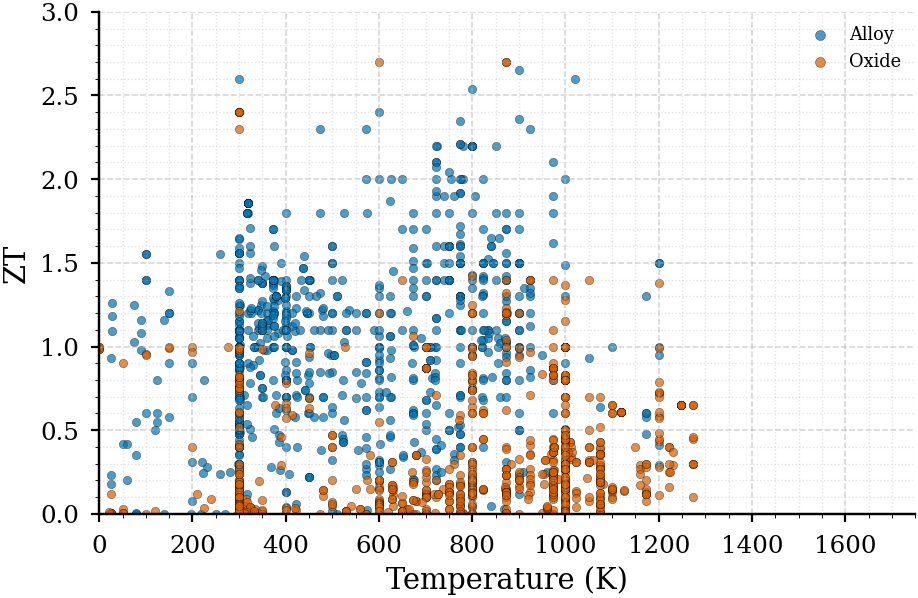

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import math

# ---------- Styling (no external LaTeX required) ----------
plt.style.use("seaborn-v0_8-paper")
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Computer Modern Roman"],
    "axes.labelsize": 13,
    "axes.titlesize": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 1.1,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
})

# ---------- Extract ZT vs Temperature for alloys and oxides ----------
records = []
for _, row in df.iterrows():
    ctype = str(row.get("compound_type", "")).strip().lower()
    if ctype in {"alloy", "oxide"}:
        zt_list = row.get("ZT_values")
        if isinstance(zt_list, list):
            for entry in zt_list:
                if isinstance(entry, dict):
                    # Accept a few possible temperature key variants
                    tkey = next((k for k in entry.keys() if k.lower() in
                                {"zt_temperature", "zt_temp", "temperature"}), None)
                    if "value" in entry and tkey in entry:
                        try:
                            temp = float(entry[tkey])
                            val  = float(entry["value"])
                            # keep only non-nan and within desired plotting bounds
                            if not (math.isnan(temp) or math.isnan(val)):
                                records.append({"compound_type": ctype, "Temperature": temp, "ZT": val})
                        except (TypeError, ValueError):
                            pass

zt_df = pd.DataFrame.from_records(records)
zt_df = zt_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["Temperature", "ZT"])

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)

# Okabe–Ito (colorblind-friendly) colors
colors = {"alloy": "#0072B2", "oxide": "#D55E00"}  # blue, vermilion

# Smaller markers with subtle edge for print clarity
for ctype, group in zt_df.groupby("compound_type", sort=False):
    ax.scatter(group["Temperature"], group["ZT"],
               s=14, alpha=0.7,
               color=colors.get(ctype, "#555555"),
               edgecolors="black", linewidths=0.2,
               label=ctype.capitalize())

# Axes, limits, ticks
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("ZT")
ax.set_xlim(0, 1750)
ax.set_ylim(0, 3)

# Grid & spines
ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.55, linewidth=0.7)
ax.grid(True, which="minor", axis="both", linestyle=":",  alpha=0.35, linewidth=0.6)
ax.minorticks_on()
for s in ("top", "right"):
    ax.spines[s].set_visible(False)

# Title & legend
#ax.set_title("ZT vs Temperature for Alloy and Oxide", pad=6)
leg = ax.legend(frameon=False, handletextpad=0.6, borderaxespad=0.4, markerscale=1.2)

plt.tight_layout()
plt.savefig("zt_vs_temperature_alloy_oxide.png", dpi=700, bbox_inches="tight")
plt.savefig("zt_vs_temperature_alloy_oxide.pdf", bbox_inches="tight")  # vector for journals
plt.show()


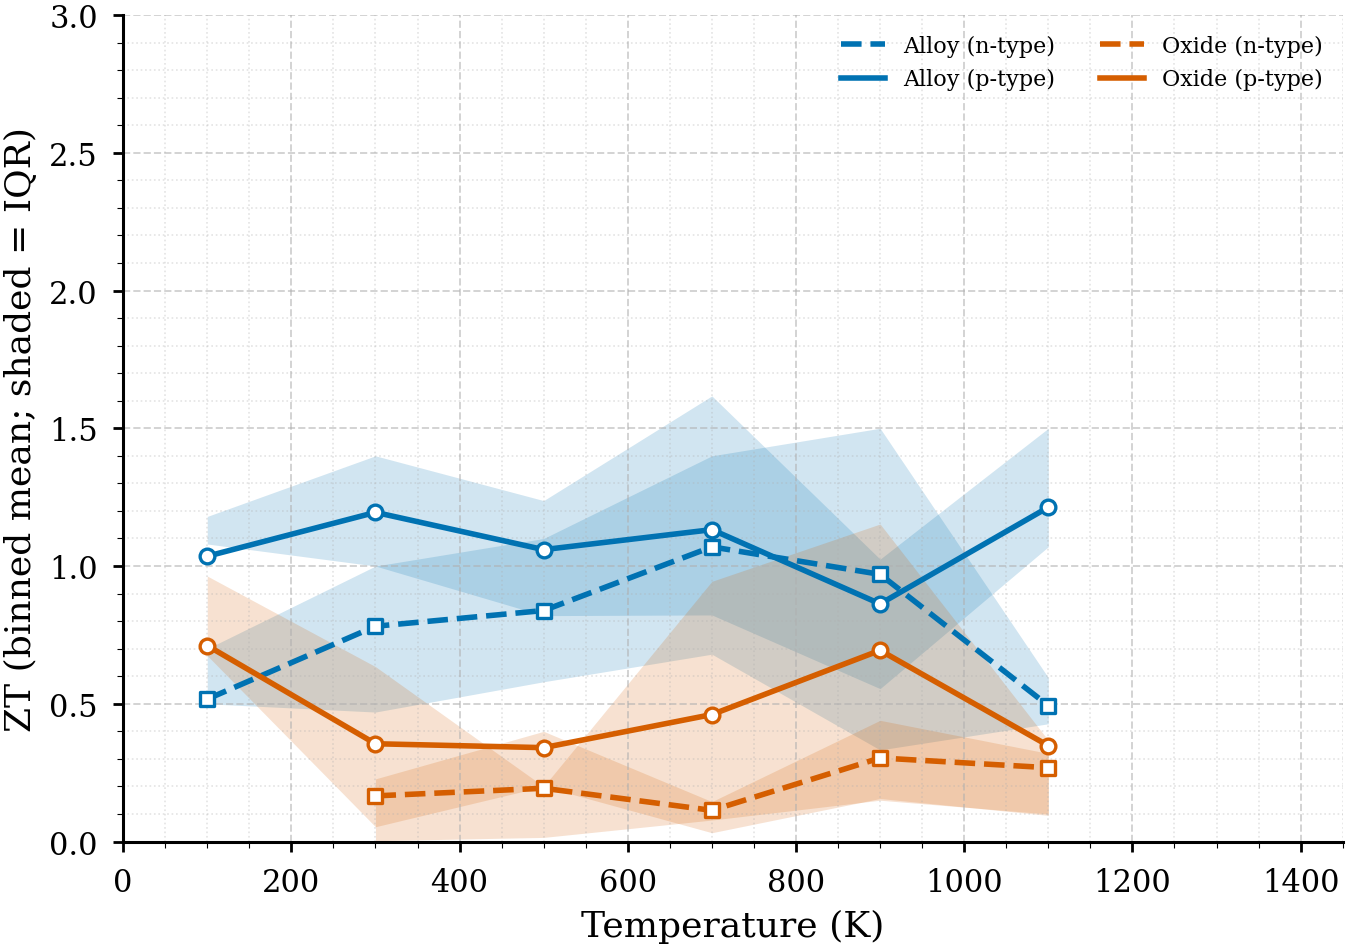

In [ ]:
# --- ZT vs Temperature: alloy/oxide × p/n (binned means + IQR) — Journal style ---
import re, ast, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl

# =========================
# 1) Helpers
# =========================
def parse_obj(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    try: return ast.literal_eval(str(x))
    except Exception: return []

def normalize_doping(x):
    if not isinstance(x, str): return None
    s = x.lower().strip()
    if re.search(r"\bp[-\s]?type\b", s): return "p-type"
    if re.search(r"\bn[-\s]?type\b", s): return "n-type"
    return None

# =========================
# 2) Extract ZT, Temperature with compound + doping
# =========================
records = []
for _, row in df.iterrows():
    ctype = str(row.get("compound_type", "")).lower().strip()
    dtype = normalize_doping(row.get("doping.doping_type", ""))
    if ctype in {"alloy", "oxide"} and dtype in {"p-type", "n-type"}:
        for entry in parse_obj(row.get("ZT_values", None)):
            if isinstance(entry, dict):
                tkey = next((k for k in entry.keys() if k.lower() in
                             {"zt_temperature", "zt_temp", "temperature"}), None)
                if "value" in entry and tkey in entry:
                    try:
                        temp = float(entry[tkey])
                        val  = float(entry["value"])
                        if np.isfinite(temp) and np.isfinite(val):
                            records.append({
                                "compound_type": ctype,
                                "doping_type": dtype,
                                "Temperature": temp,
                                "ZT": val
                            })
                    except Exception:
                        pass

zt_df = pd.DataFrame(records)
if zt_df.empty:
    raise ValueError("No ZT entries found for alloy/oxide with p-type/n-type labels.")
# =========================
# 2b) Outlier removal (IQR filter for each group)
# =========================
zt_cleaned = []
for (ctype, dtype), g in zt_df.groupby(["compound_type","doping_type"]):
    if len(g) < 5:
        zt_cleaned.append(g)   # skip filtering if too few points
        continue
    Q1 = g["ZT"].quantile(0.25)
    Q3 = g["ZT"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    g_filt = g[(g["ZT"] >= lower) & (g["ZT"] <= upper)]
    zt_cleaned.append(g_filt)

zt_df = pd.concat(zt_cleaned, ignore_index=True)

# =========================
# 3) Binning
# =========================
BIN_WIDTH = 200    # adjust if needed
MIN_COUNT = 3       # minimum points per bin to show

tmin = np.floor(zt_df["Temperature"].min() // BIN_WIDTH) * BIN_WIDTH
tmax = np.ceil(zt_df["Temperature"].max() // BIN_WIDTH) * BIN_WIDTH
bins = np.arange(tmin, tmax + BIN_WIDTH, BIN_WIDTH)
centers = (bins[:-1] + bins[1:]) / 2.0

zt_df["T_bin"] = pd.cut(zt_df["Temperature"], bins=bins, labels=centers, include_lowest=True)

agg = (zt_df
       .groupby(["compound_type","doping_type","T_bin"], observed=True)
       .agg(ZT_mean=("ZT","mean"),
            ZT_median=("ZT","median"),
            ZT_q25=("ZT", lambda x: np.percentile(x, 25)),
            ZT_q75=("ZT", lambda x: np.percentile(x, 75)),
            N=("ZT","size"))
       .reset_index())

agg = agg[agg["N"] >= MIN_COUNT].copy()
agg["T_bin"]   = pd.to_numeric(agg["T_bin"], errors="coerce")
for col in ["ZT_mean","ZT_q25","ZT_q75"]:
    agg[col] = pd.to_numeric(agg[col], errors="coerce")

# =========================
# 4) Journal plotting
# =========================
plt.style.use("seaborn-v0_8-paper")
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif", "Computer Modern Roman"],
    "axes.labelsize": 13,
    "axes.titlesize": 15,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 1.1,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "axes.unicode_minus": False,
})

# Colorblind-friendly colors + linestyles to separate groups clearly
color_map = {"alloy": "#0072B2", "oxide": "#D55E00"}     # Okabe–Ito: blue, vermilion
style_map = {"p-type": "-", "n-type": "--"}
marker_map = {"p-type": "o", "n-type": "s"}

fig, ax = plt.subplots(figsize=(7, 5), dpi=200)

for (ctype, dtype), g in agg.groupby(["compound_type","doping_type"]):
    g = g.sort_values("T_bin")
    x = g["T_bin"].values
    y = g["ZT_mean"].values
    q25 = g["ZT_q25"].values
    q75 = g["ZT_q75"].values

    ax.plot(x, y,
            linestyle=style_map.get(dtype, "-"),
            color=color_map.get(ctype, "#555555"),
            linewidth=2.0,
            label=f"{ctype.capitalize()} ({dtype})")
    ax.scatter(x, y,
               s=28,
               facecolors="white",
               edgecolors=color_map.get(ctype, "#555555"),
               linewidths=1.2,
               marker=marker_map.get(dtype, "o"),
               zorder=3)

    # IQR band
    if np.isfinite(q25).any() and np.isfinite(q75).any():
        ax.fill_between(x, q25, q75,
                        color=color_map.get(ctype, "#555555"),
                        alpha=0.18, linewidth=0)

# Axes labels & limits (journal-friendly bounds)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("ZT (binned mean; shaded = IQR)")
ax.set_xlim(0, 1450)   # tighten if you prefer your earlier range
ax.set_ylim(0, 3)

# Minor ticks, grid, and spines
ax.minorticks_on()
ax.grid(True, which="major", axis="both", linestyle="--", linewidth=0.7, alpha=0.55)
ax.grid(True, which="minor", axis="both", linestyle=":",  linewidth=0.6, alpha=0.35)
for s in ("top", "right"):
    ax.spines[s].set_visible(False)

# Title & legend
#ax.set_title(f"ZT vs Temperature by Compound & Doping  (bin = {BIN_WIDTH} K; min N = {MIN_COUNT})", pad=6)
ax.legend(frameon=False, ncols=2)

plt.tight_layout()
plt.savefig("zt_vs_temp_binned_mean_iqr.png", dpi=700, bbox_inches="tight")
plt.savefig("zt_vs_temp_binned_mean_iqr.pdf", bbox_inches="tight")  # vector for print
plt.show()


In [ ]:
# =========================
# Count points per group (4 combinations)
# =========================
group_counts = (
    zt_df
    .groupby(["compound_type","doping_type"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print(group_counts)


  compound_type doping_type  count
1         alloy      p-type    156
0         alloy      n-type    144
2         oxide      n-type    100
3         oxide      p-type     49


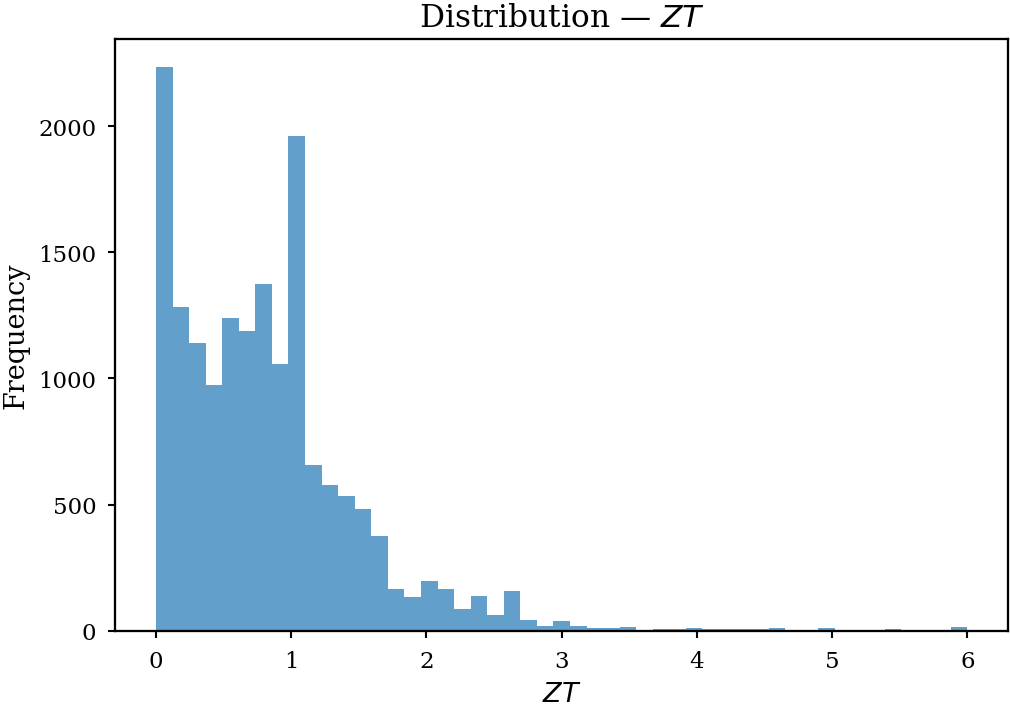

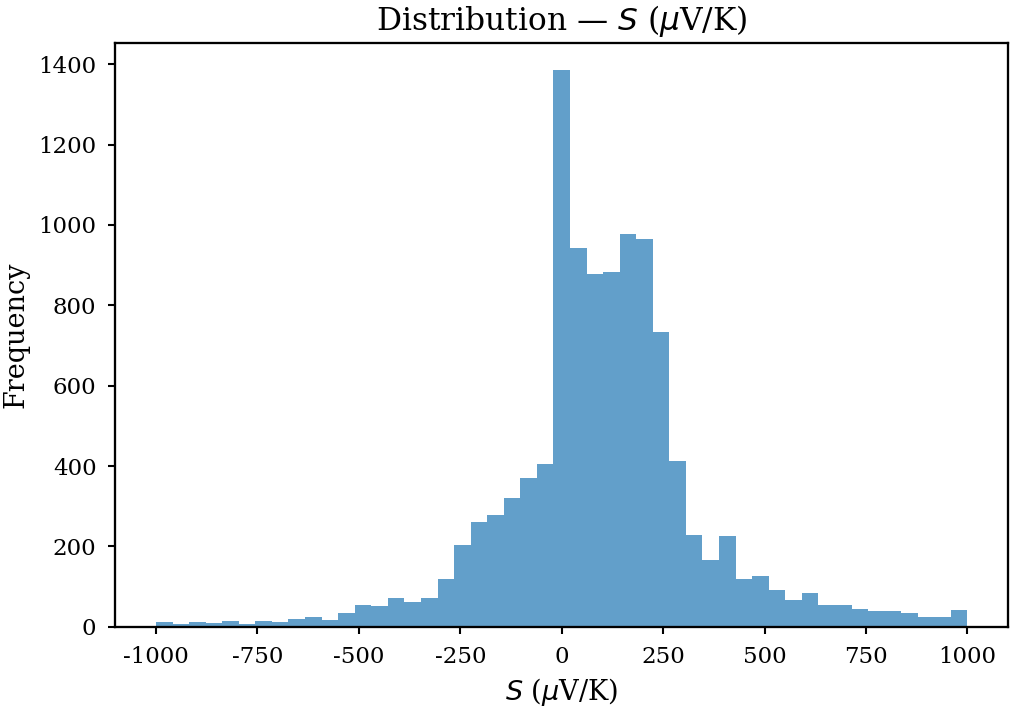

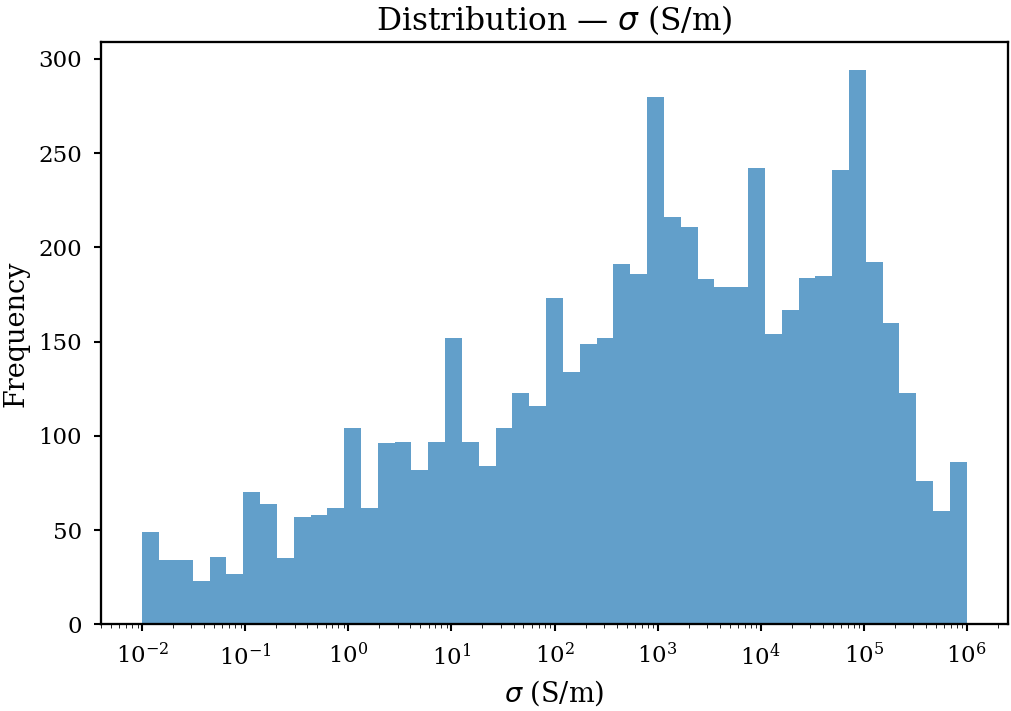

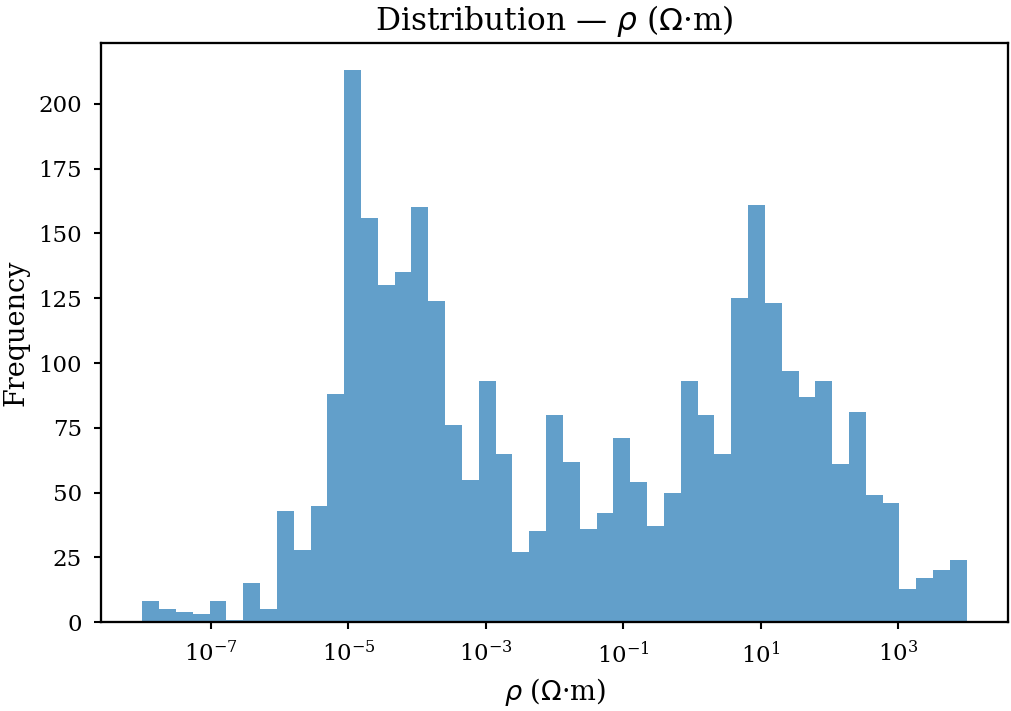

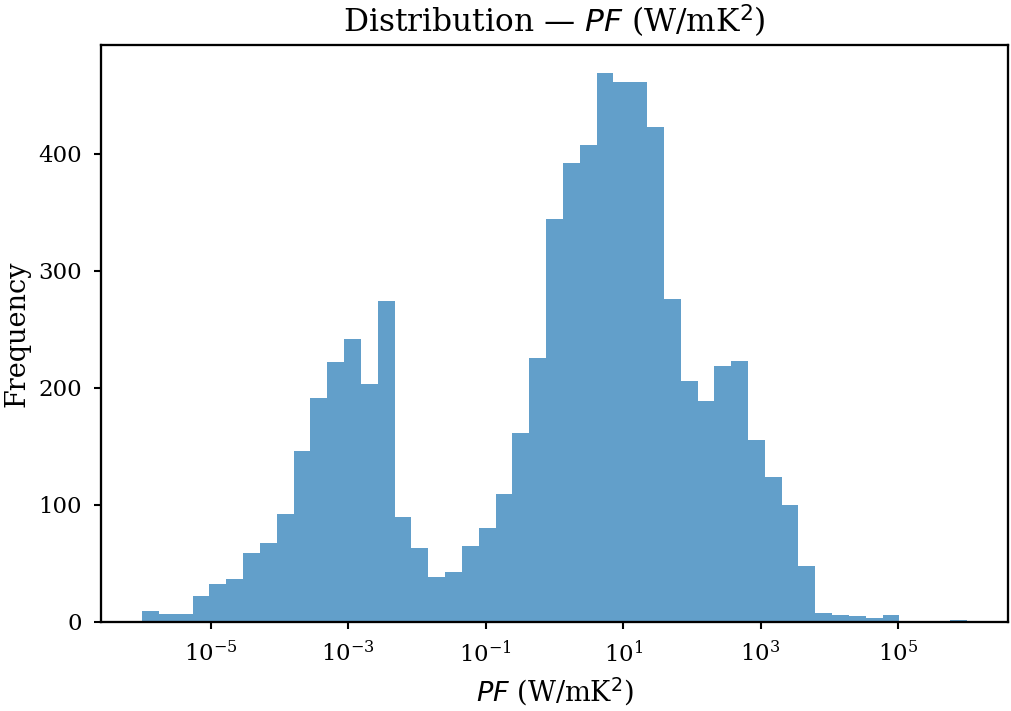

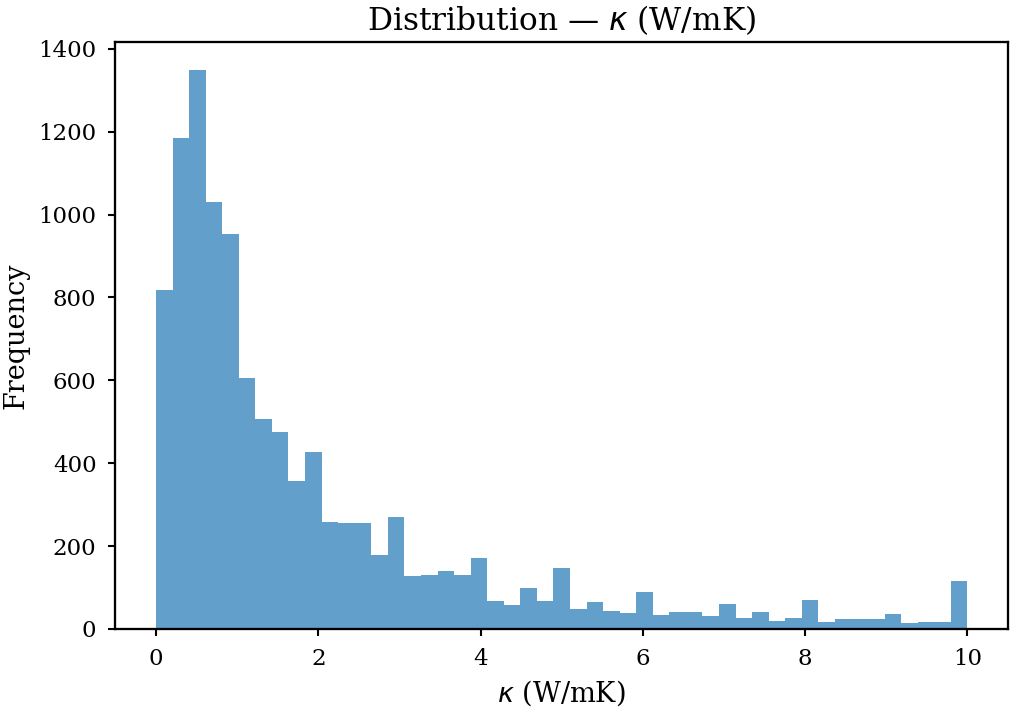

In [ ]:
# Plot histograms in canonical units
plot_histograms(tidy)


In [ ]:
tidy

,doi_key,material,property,value_std,unit_std
0,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.40,
1,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.36,
2,10.1007/s11837-013-0609-0,Bi0.5Sb1.5Te3,zt_values,1.50,
3,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.50,
4,10.1016/j.actamat.2017.09.029,AgBiSe2,zt_values,0.30,
...,...,...,...,...,...
60655,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,0.50,W/mK
60656,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,1.20,W/mK
60657,10.1039/c5ra23634g,Bi1.75Sb0.25Te2.02 NW (250 nm diameter),thermal_conductivity,1.40,W/mK
60658,10.1016/j.tsf.2021.138948,Bi0.95Sb0.05,thermal_conductivity,2.00,W/mK


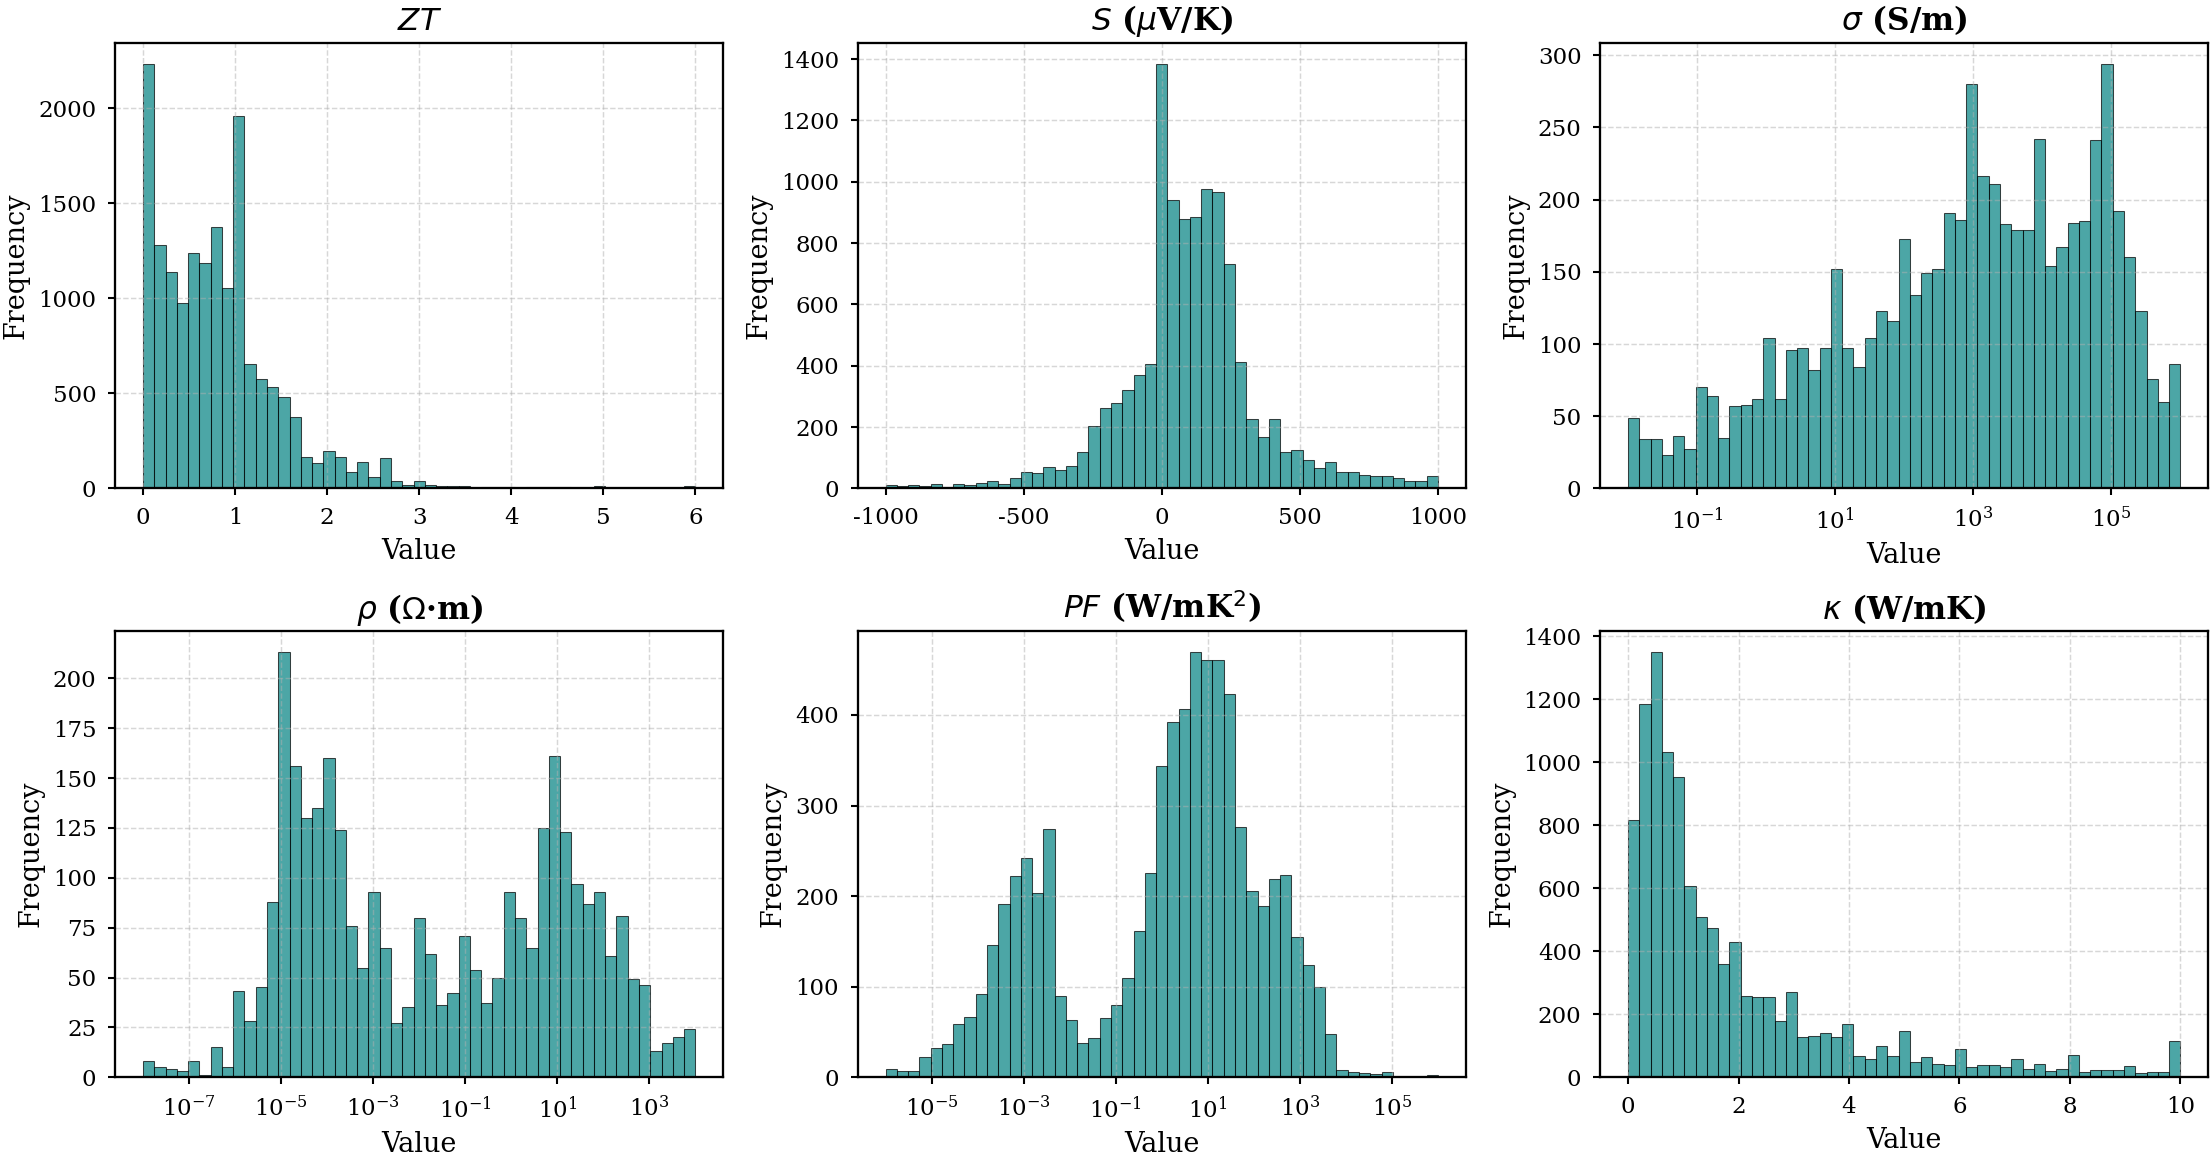

✅ Saved high-quality figures (PNG+PDF) in ./figs


In [ ]:
# =========================
# Plot histograms (using standardized arrays)
# =========================
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Define the variables that were causing the NameError
properties = ["zt_values","seebeck_coefficient","electrical_conductivity",
              "electrical_resistivity","power_factor","thermal_conductivity"]

# Create a dictionary of property distributions from the tidy DataFrame
property_distributions = {
    prop: tidy[tidy["property"] == prop]["value_std"].dropna().values
    for prop in properties
}

# Use the BINS defined in the previous cell
custom_bins = BINS

# Use the TITLES defined in the previous cell for labels
labels = TITLES

for ax, prop in zip(axes, properties):
    if prop in property_distributions:
        bins = custom_bins[prop]
        ax.hist(property_distributions[prop], bins=bins, color='teal', alpha=0.7,
                edgecolor="black", linewidth=0.5)
        ax.set_title(labels[prop], fontweight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        # Use log x-scale if bins span orders of magnitude
        if np.all(bins > 0) and np.ptp(np.log10(bins)) > 1:
            ax.set_xscale("log")
        ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.7)
    else:
        ax.set_visible(False)

plt.tight_layout()

# Save both PNG (600 dpi) and PDF (vector)
outdir = "./figs"   # change this if you want; use "/content" in Colab
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, "thermo_property_distributions.png"), dpi=1200, bbox_inches="tight")
plt.savefig(os.path.join(outdir, "thermo_property_distributions.pdf"), bbox_inches="tight")

plt.show()
print("✅ Saved high-quality figures (PNG+PDF) in", outdir)

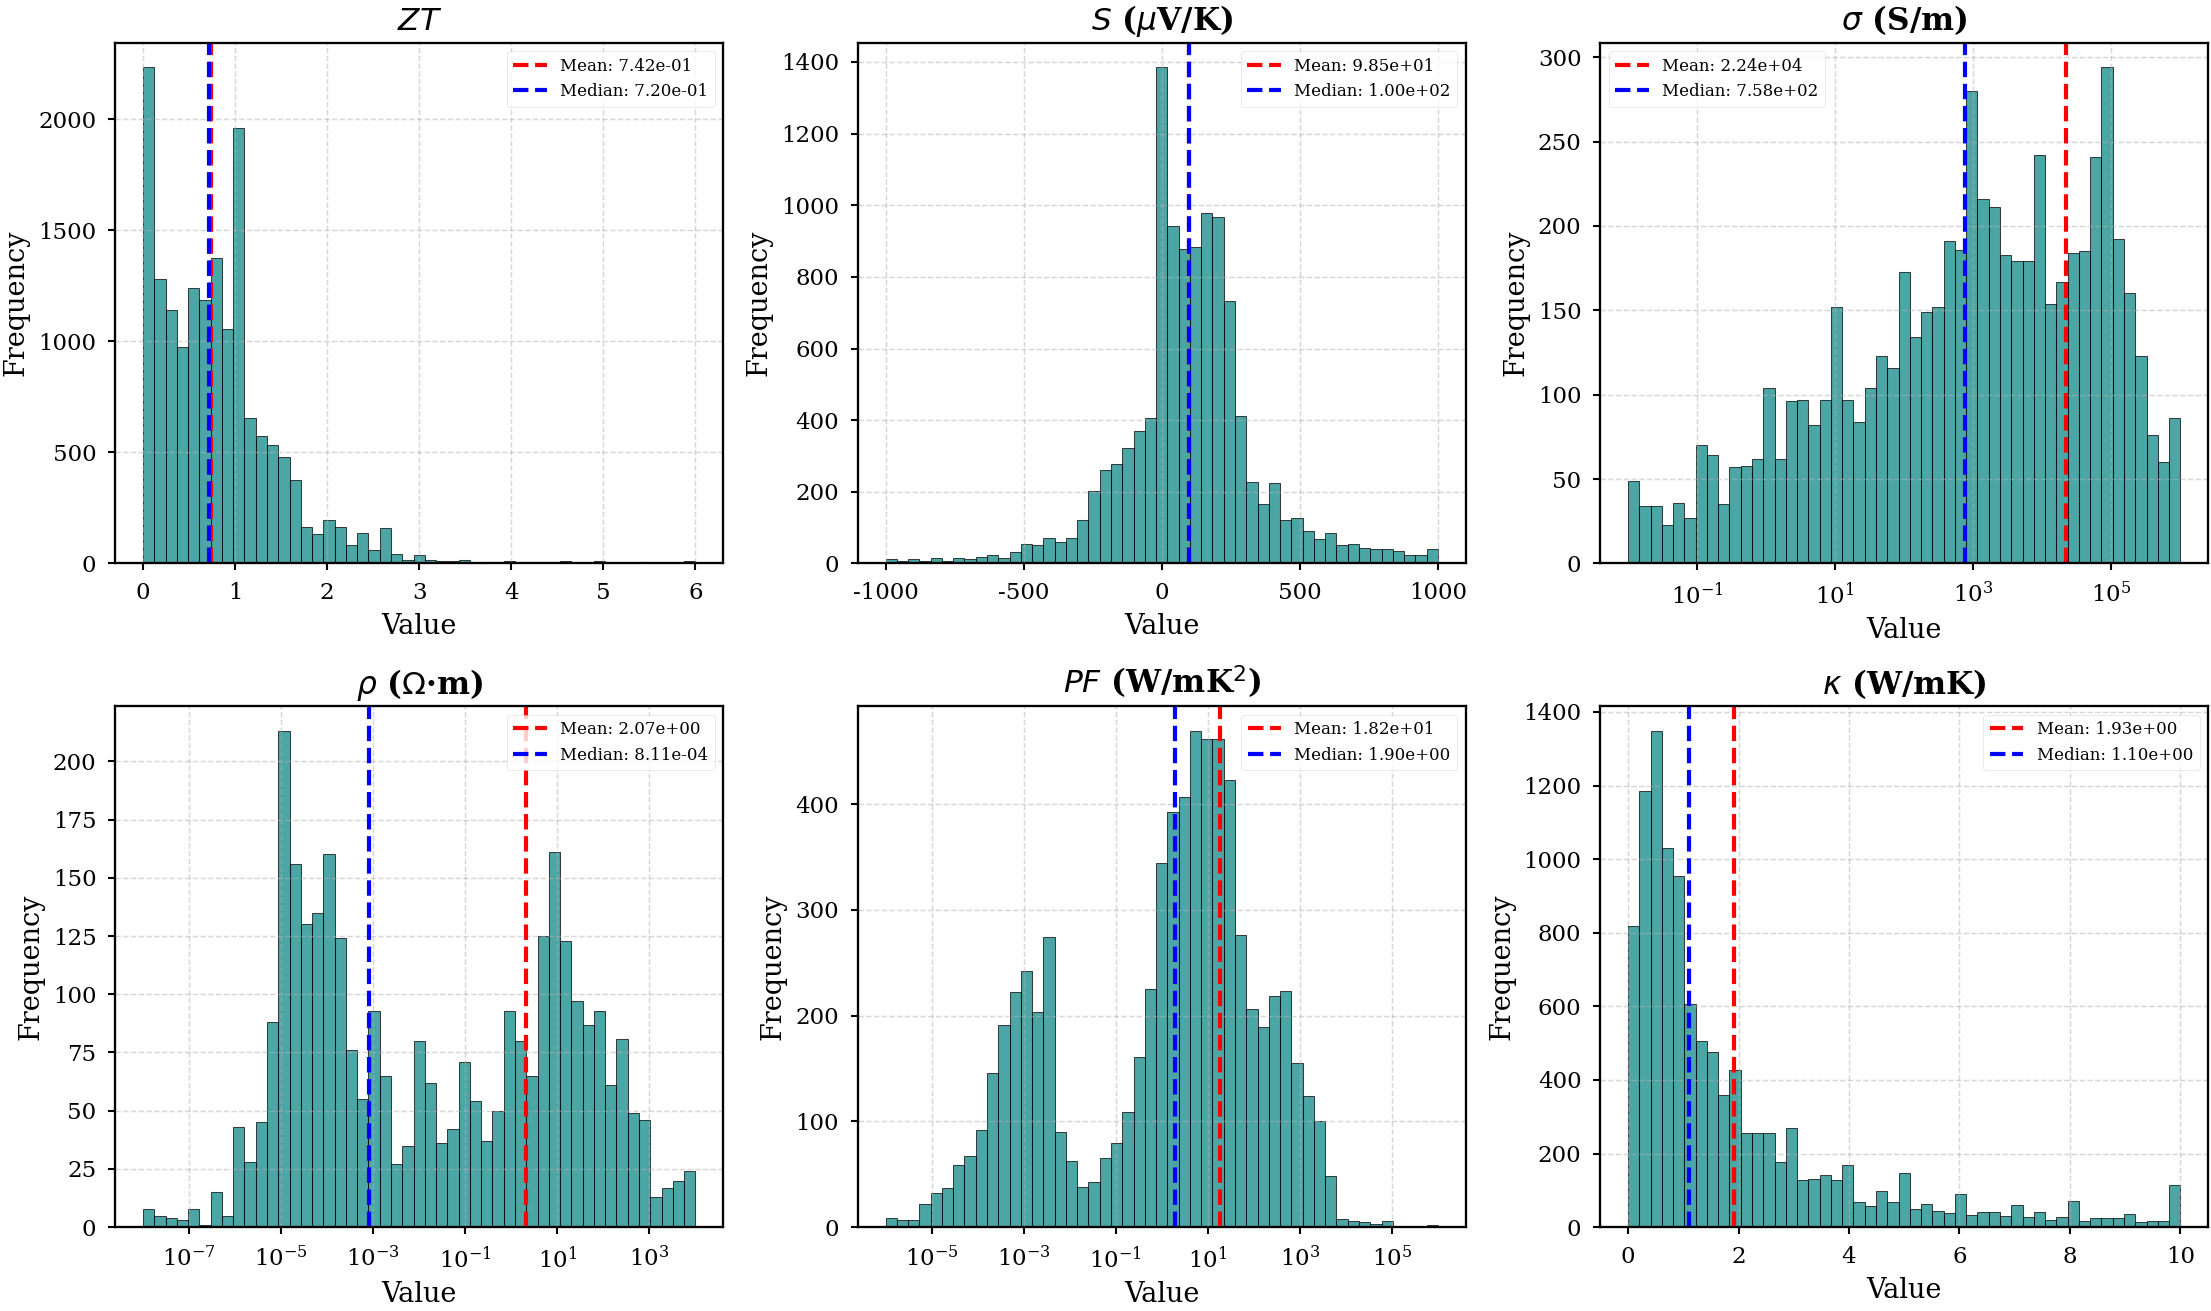


📊 STATISTICAL SUMMARY (CALCULATED WITHOUT OUTLIERS)


,Property,Count,Mean,Median,Std Dev
0,$ZT$,15819,0.742,0.720,0.527
1,$S$ ($\mu$V/K),10260,98.499,100.000,174.277
2,$\sigma$ (S/m),6365,2.241e+04,758.000,4.934e+04
3,$\rho$ ($\Omega$·m),2668,2.071,8.115e-04,4.777
4,$PF$ (W/mK$^2$),6279,18.226,1.900,41.890
5,$\kappa$ (W/mK),11039,1.926,1.100,2.118


'# =========================\n# Outlier Removal Summary\n# =========================\nprint("\n🗑️ OUTLIER SUMMARY")\nprint("=" * 80)\n\noutlier_df = pd.DataFrame({\n    \'Property\': [labels[prop] for prop in properties if prop in outlier_info],\n    \'Total Data\': [outlier_info[prop][\'original_count\'] for prop in properties if prop in outlier_info],\n    \'Outliers\': [outlier_info[prop][\'outliers_removed\'] for prop in properties if prop in outlier_info],\n    \'Percentage\': [f"{outlier_info[prop][\'outlier_percentage\']:.1f}%" for prop in properties if prop in outlier_info],\n    \'Lower Bound\': [f"{outlier_info[prop][\'lower_bound\']:.2e}" for prop in properties if prop in outlier_info],\n    \'Upper Bound\': [f"{outlier_info[prop][\'upper_bound\']:.2e}" for prop in properties if prop in outlier_info]\n})\n\ndisplay(outlier_df)\n\n# =========================\n# Additional Analysis\n# =========================\nprint("\n🔍 DISTRIBUTION CHARACTERISTICS (STATS CALCULATED WITHOUT 

In [ ]:
# Define outlier removal function
def remove_outliers_iqr(data, prop):
    """
    Remove outliers using the Interquartile Range (IQR) method
    Returns: data without outliers, lower_bound, upper_bound
    """
    if len(data) == 0:
        return data, 0, 0

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Use tighter bounds for properties with wide ranges
    if prop in ["electrical_conductivity", "electrical_resistivity", "power_factor"]:
        # More conservative bounds for log-scale properties
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    else:
        # Standard bounds for other properties
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    # Ensure bounds are physically meaningful
    if prop == "zt_values":
        lower_bound = max(lower_bound, 0)  # ZT can't be negative
    elif prop == "seebeck_coefficient":
        # Seebeck can be negative but let's be reasonable
        lower_bound = max(lower_bound, -2000)
    elif prop == "thermal_conductivity":
        lower_bound = max(lower_bound, 0)  # Thermal conductivity can't be negative

    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_data, lower_bound, upper_bound

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

properties = ["zt_values","seebeck_coefficient","electrical_conductivity",
              "electrical_resistivity","power_factor","thermal_conductivity"]

# Create a dictionary of property distributions from the tidy DataFrame
property_distributions = {
    prop: tidy[tidy["property"] == prop]["value_std"].dropna().values
    for prop in properties
}

# Keep the original bin ranges for all properties
custom_bins = {
    "zt_values": np.linspace(0, 6, 50),                 # ZT
    "seebeck_coefficient": np.linspace(-1000, 1000, 50),# μV/K
    "electrical_conductivity": np.logspace(-2, 6, 50),  # S/m
    "electrical_resistivity": np.logspace(-8, 4, 50),   # Ω·m
    "power_factor": np.logspace(-6, 6, 50),             # W/mK^2
    "thermal_conductivity": np.linspace(0, 10, 50),     # W/mK
}

labels = TITLES

# Dictionary to store statistics (without outliers)
stats_results = {}
outlier_info = {}

for ax, prop in zip(axes, properties):
    if prop in property_distributions and len(property_distributions[prop]) > 0:
        original_data = property_distributions[prop]

        # Remove outliers to calculate statistics
        filtered_data, lower_bound, upper_bound = remove_outliers_iqr(original_data, prop)
        outliers_removed = len(original_data) - len(filtered_data)
        outlier_percentage = (outliers_removed / len(original_data)) * 100

        outlier_info[prop] = {
            'original_count': len(original_data),
            'filtered_count': len(filtered_data),
            'outliers_removed': outliers_removed,
            'outlier_percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        if len(filtered_data) == 0:
            ax.set_visible(False)
            continue

        # Calculate statistics on filtered data (without outliers)
        mean_val = np.mean(filtered_data)
        median_val = np.median(filtered_data)
        std_val = np.std(filtered_data)

        # Store results
        stats_results[prop] = {
            'mean': mean_val,
            'median': median_val,
            'std': std_val,
            'count': len(filtered_data)
        }

        # Use the original fixed bin ranges for all properties
        bins = custom_bins[prop]

        # Plot histogram of ALL data (including outliers)
        ax.hist(original_data, bins=bins, color='teal', alpha=0.7,
                edgecolor="black", linewidth=0.5)


        title = f"{labels[prop]}"
        ax.set_title(title, fontweight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        # Use log x-scale for properties that use logspace bins
        if prop in ["electrical_conductivity", "electrical_resistivity", "power_factor"]:
            ax.set_xscale("log")

        # Add mean and median lines calculated from data WITHOUT outliers
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_val:.2e}')
        ax.axvline(median_val, color='blue', linestyle='--', linewidth=2,
                  label=f'Median: {median_val:.2e}')

        ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.7)
        ax.legend()

    else:
        ax.set_visible(False)

plt.tight_layout()

# Save both PNG (600 dpi) and PDF (vector)
outdir = "./figs"
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, "thermo_property_distributions_with_outliers_stats.png"), dpi=600, bbox_inches="tight")
plt.savefig(os.path.join(outdir, "thermo_property_distributions_with_outliers_stats.pdf"), bbox_inches="tight")

plt.show()

# =========================
# Display Statistics Table (Without Outliers)
# =========================
print("\n📊 STATISTICAL SUMMARY (CALCULATED WITHOUT OUTLIERS)")
print("=" * 80)

# Create a DataFrame for nice display
stats_df = pd.DataFrame({
    'Property': [labels[prop] for prop in properties if prop in stats_results],
    'Count': [stats_results[prop]['count'] for prop in properties if prop in stats_results],
    'Mean': [stats_results[prop]['mean'] for prop in properties if prop in stats_results],
    'Median': [stats_results[prop]['median'] for prop in properties if prop in stats_results],
    'Std Dev': [stats_results[prop]['std'] for prop in properties if prop in stats_results]
})

# Format numbers for better readability
def format_number(x):
    if abs(x) < 0.001 or abs(x) > 10000:
        return f"{x:.3e}"
    else:
        return f"{x:.3f}"

stats_df['Mean'] = stats_df['Mean'].apply(format_number)
stats_df['Median'] = stats_df['Median'].apply(format_number)
stats_df['Std Dev'] = stats_df['Std Dev'].apply(format_number)

display(stats_df)

'''# =========================
# Outlier Removal Summary
# =========================
print("\n🗑️ OUTLIER SUMMARY")
print("=" * 80)

outlier_df = pd.DataFrame({
    'Property': [labels[prop] for prop in properties if prop in outlier_info],
    'Total Data': [outlier_info[prop]['original_count'] for prop in properties if prop in outlier_info],
    'Outliers': [outlier_info[prop]['outliers_removed'] for prop in properties if prop in outlier_info],
    'Percentage': [f"{outlier_info[prop]['outlier_percentage']:.1f}%" for prop in properties if prop in outlier_info],
    'Lower Bound': [f"{outlier_info[prop]['lower_bound']:.2e}" for prop in properties if prop in outlier_info],
    'Upper Bound': [f"{outlier_info[prop]['upper_bound']:.2e}" for prop in properties if prop in outlier_info]
})

display(outlier_df)

# =========================
# Additional Analysis
# =========================
print("\n🔍 DISTRIBUTION CHARACTERISTICS (STATS CALCULATED WITHOUT OUTLIERS):")
print("=" * 80)

for prop in properties:
    if prop in stats_results:
        original_data = property_distributions[prop]
        filtered_data, _, _ = remove_outliers_iqr(original_data, prop)
        mean_val = stats_results[prop]['mean']
        median_val = stats_results[prop]['median']

        # Check if distribution is skewed
        skewness = (mean_val - median_val) / stats_results[prop]['std'] if stats_results[prop]['std'] > 0 else 0

        if abs(skewness) > 0.5:
            skew_direction = "significantly skewed"
        else:
            skew_direction = "relatively symmetric"

        print(f"{labels[prop]:<30}: {skew_direction} (skewness: {skewness:.2f})")
        print(f"  Full data range: {np.min(original_data):.2e} to {np.max(original_data):.2e}")
        print(f"  Clean data range: {np.min(filtered_data):.2e} to {np.max(filtered_data):.2e}")
        print()

print("✅ Saved figures showing full data with outlier-removed statistics (PNG+PDF) in", outdir)'''

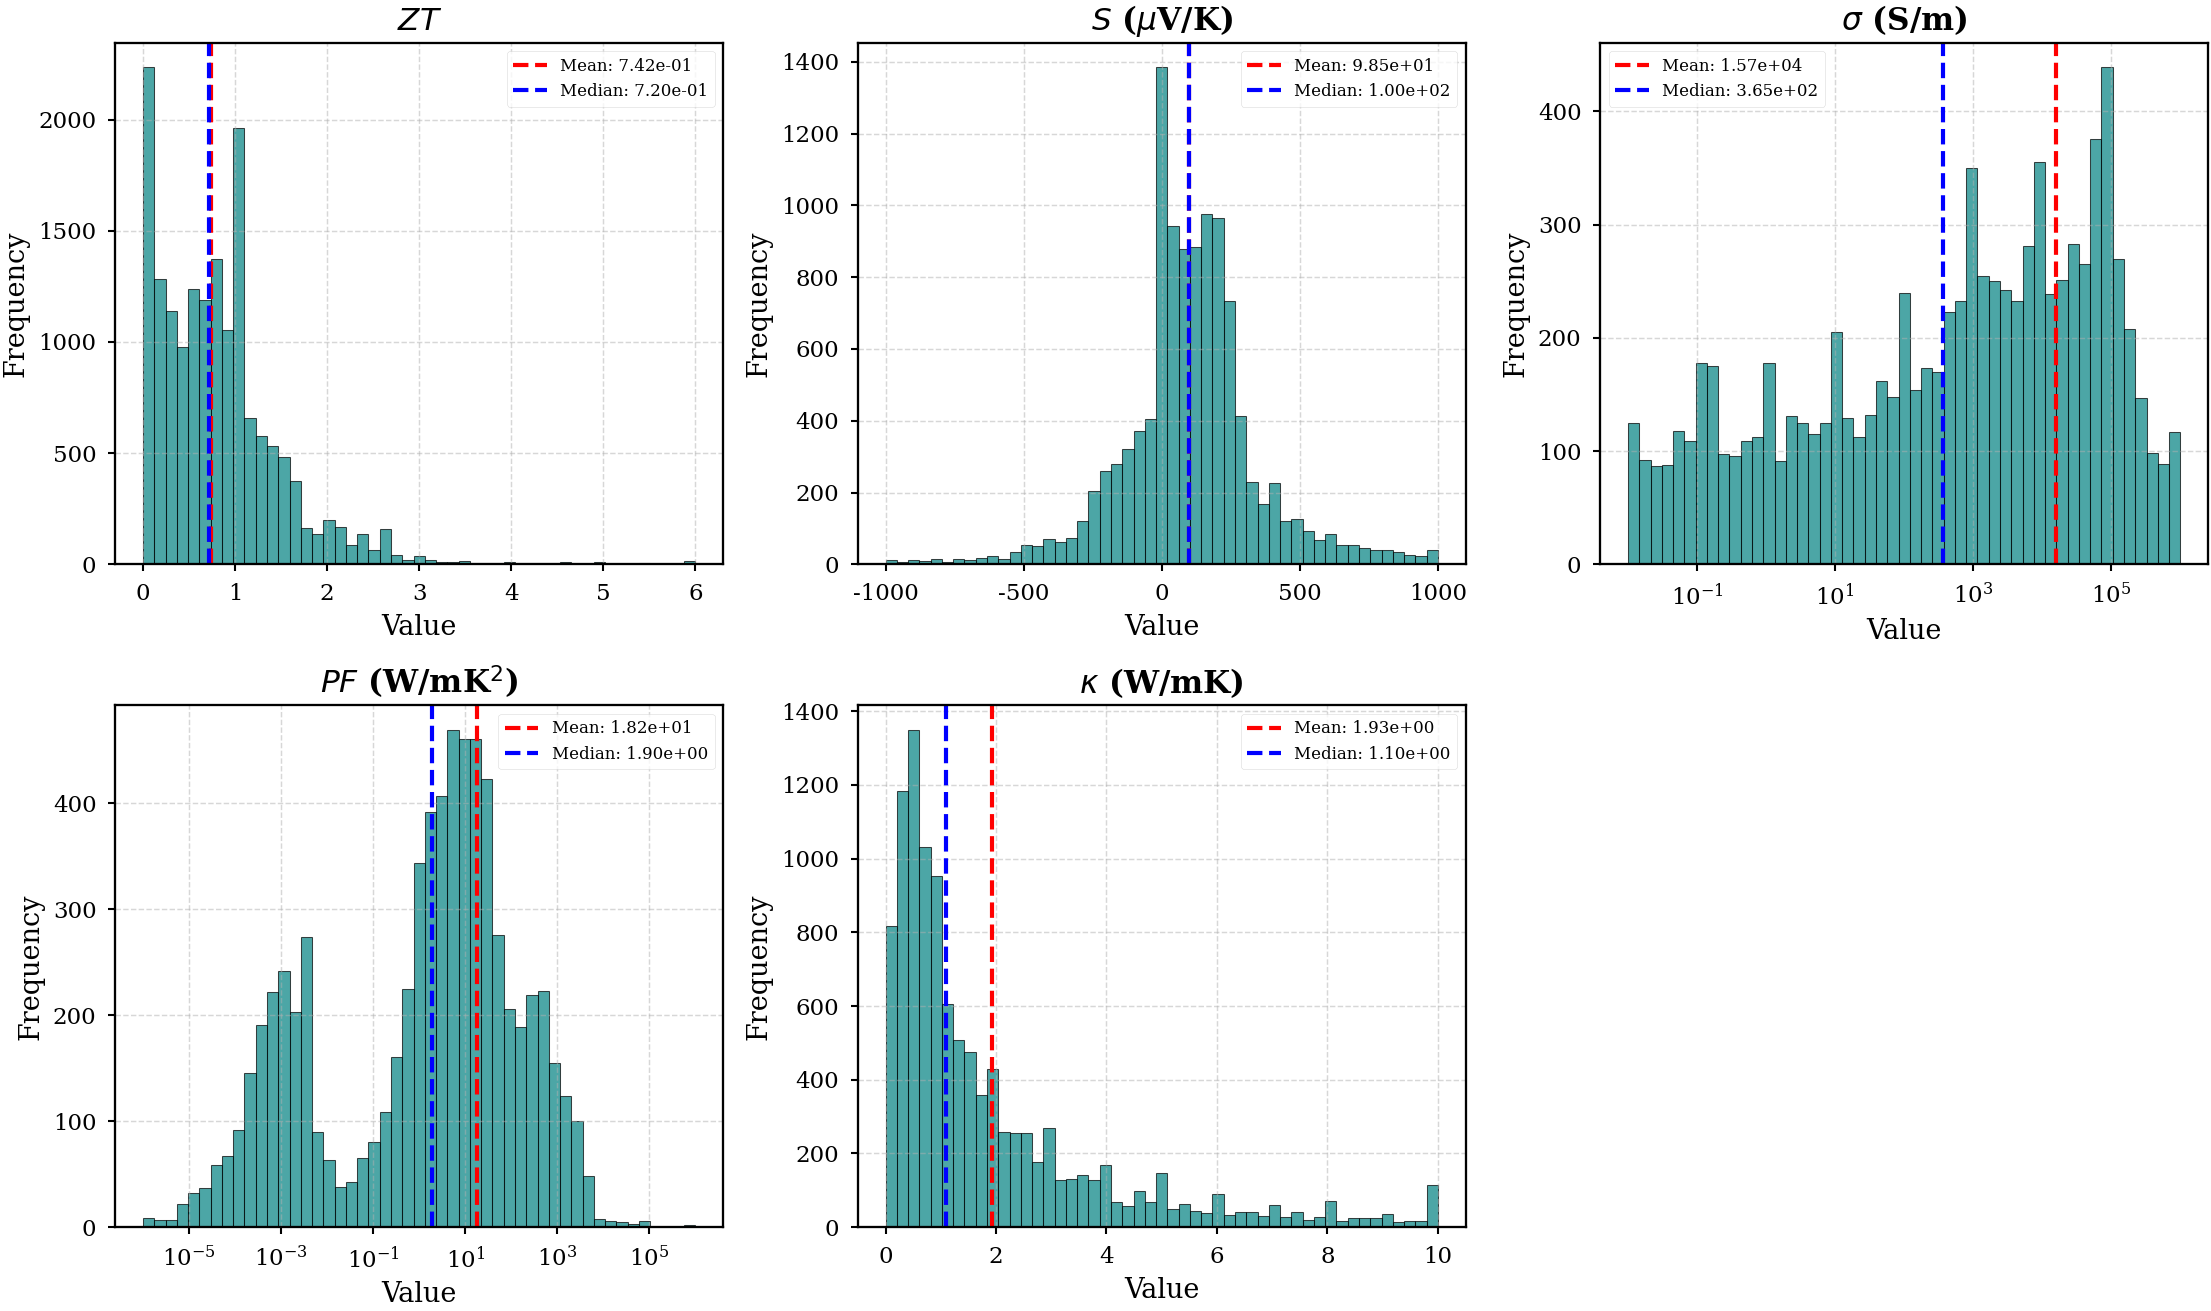


📊 STATISTICAL SUMMARY (NO OUTLIERS)


,Property,Count,Mean,Median,Std Dev
0,$ZT$,15819,0.742,0.720,0.527
1,$S$ ($\mu$V/K),10260,98.499,100.000,174.277
2,$\sigma$ (S/m),9274,1.568e+04,364.600,3.325e+04
3,$PF$ (W/mK$^2$),6279,18.226,1.900,41.890
4,$\kappa$ (W/mK),11039,1.926,1.100,2.118


In [ ]:

# =========================
# Helper: Outlier Removal
# =========================
def remove_outliers_iqr(data, prop):
    if len(data) == 0:
        return data, 0, 0

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Physical constraints
    if prop == "zt_values":
        lower_bound = max(lower_bound, 0)
    elif prop == "seebeck_coefficient":
        lower_bound = max(lower_bound, -2000)
    elif prop == "thermal_conductivity":
        lower_bound = max(lower_bound, 0)
    elif prop == "electrical_conductivity":
        lower_bound = max(lower_bound, 0)

    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
    return filtered_data, lower_bound, upper_bound

# =========================
# Build property distributions
# =========================
properties = ["zt_values", "seebeck_coefficient",
              "electrical_conductivity", "power_factor",
              "thermal_conductivity"]

# Extract distributions
property_distributions = {
    prop: tidy[tidy["property"] == prop]["value_std"].dropna().values
    for prop in properties if prop != "electrical_conductivity"
}

# Handle conductivity + resistivity together
conductivity = tidy[tidy["property"] == "electrical_conductivity"]["value_std"].dropna().values
resistivity = tidy[tidy["property"] == "electrical_resistivity"]["value_std"].dropna().values

# Convert resistivity → conductivity (σ = 1/ρ), ignore invalid
resistivity_to_cond = 1.0 / resistivity[resistivity != 0]
combined_conductivity = np.concatenate([conductivity, resistivity_to_cond])
property_distributions["electrical_conductivity"] = combined_conductivity

# =========================
# Binning setup
# =========================
custom_bins = {
    "zt_values": np.linspace(0, 6, 50),
    "seebeck_coefficient": np.linspace(-1000, 1000, 50),
    "electrical_conductivity": np.logspace(-2, 6, 50),
    "power_factor": np.logspace(-6, 6, 50),
    "thermal_conductivity": np.linspace(0, 10, 50),
}

# Labels
labels = TITLES

# =========================
# Plot histograms
# =========================
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

stats_results = {}
outlier_info = {}

for ax, prop in zip(axes, properties):
    if prop in property_distributions and len(property_distributions[prop]) > 0:
        original_data = property_distributions[prop]

        # Remove outliers
        filtered_data, lower_bound, upper_bound = remove_outliers_iqr(original_data, prop)
        outliers_removed = len(original_data) - len(filtered_data)
        outlier_percentage = (outliers_removed / len(original_data)) * 100

        outlier_info[prop] = {
            'original_count': len(original_data),
            'filtered_count': len(filtered_data),
            'outliers_removed': outliers_removed,
            'outlier_percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        if len(filtered_data) == 0:
            ax.set_visible(False)
            continue

        # Stats
        mean_val = np.mean(filtered_data)
        median_val = np.median(filtered_data)
        std_val = np.std(filtered_data)

        stats_results[prop] = {
            'mean': mean_val,
            'median': median_val,
            'std': std_val,
            'count': len(filtered_data)
        }

        # Histogram
        bins = custom_bins[prop]
        ax.hist(original_data, bins=bins, color='teal', alpha=0.7,
                edgecolor="black", linewidth=0.5)

        ax.set_title(labels[prop], fontweight="bold")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")

        if prop in ["electrical_conductivity", "power_factor"]:
            ax.set_xscale("log")

        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_val:.2e}')
        ax.axvline(median_val, color='blue', linestyle='--', linewidth=2,
                   label=f'Median: {median_val:.2e}')
        ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.7)
        ax.legend()
    else:
        ax.set_visible(False)
# Hide the last one(s)
for ax in axes[len(properties):]:
    ax.set_visible(False)
plt.tight_layout()

# Save figures
outdir = "./figs"
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, "thermo_property_distributions_combined_conductivity.png"),
            dpi=600, bbox_inches="tight")
plt.savefig(os.path.join(outdir, "thermo_property_distributions_combined_conductivity.pdf"),
            bbox_inches="tight")
plt.show()

# =========================
# Stats table
# =========================
print("\n📊 STATISTICAL SUMMARY (NO OUTLIERS)")
print("=" * 80)

stats_df = pd.DataFrame({
    'Property': [labels[prop] for prop in properties if prop in stats_results],
    'Count': [stats_results[prop]['count'] for prop in properties if prop in stats_results],
    'Mean': [stats_results[prop]['mean'] for prop in properties if prop in stats_results],
    'Median': [stats_results[prop]['median'] for prop in properties if prop in stats_results],
    'Std Dev': [stats_results[prop]['std'] for prop in properties if prop in stats_results]
})

def format_number(x):
    if abs(x) < 0.001 or abs(x) > 10000:
        return f"{x:.3e}"
    else:
        return f"{x:.3f}"

stats_df['Mean'] = stats_df['Mean'].apply(format_number)
stats_df['Median'] = stats_df['Median'].apply(format_number)
stats_df['Std Dev'] = stats_df['Std Dev'].apply(format_number)

display(stats_df)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import os
from matplotlib import rcParams

# ===== Styling (no external LaTeX required) =====
rcParams.update({
    "text.usetex": False,                       # mathtext only (works in Colab)
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times", "Computer Modern Roman"],
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
    "figure.dpi": 150,                          # on-screen; export uses 600
    "axes.unicode_minus": False,
})

# ===== Inputs =====
properties = ["ZT_values", "electrical_conductivity", "electrical_resistivity",
              "seebeck_coefficient", "power_factor", "thermal_conductivity"]
property_symbols = [r"$ZT$", r"$\sigma$", r"$\rho$", r"$S$", r"$PF$", r"$\kappa$"]

# Ensure df has required columns (skip missing gracefully)
props_present = [p for p in properties if p in df.columns]
symbols_present = [property_symbols[properties.index(p)] for p in props_present]

# ===== Compute temperature coverage stats =====
temp_stats = {}
for prop in props_present:
    total_entries = 0
    with_temp = 0
    col = df[prop].dropna()
    for val in col:
        try:
            parsed = ast.literal_eval(val) if isinstance(val, str) else val
            if isinstance(parsed, list):
                total_entries += len(parsed)
                for item in parsed:
                    if isinstance(item, dict):
                        temp_key = next((k for k in item.keys()
                                         if "Temp" in k or "temp" in k), None)
                        if temp_key is not None and item[temp_key] is not None:
                            with_temp += 1
        except Exception:
            # Ignore malformed rows silently
            continue
    temp_stats[prop] = {
        "total_values": total_entries,
        "with_temperature": with_temp,
    }

# Build DataFrame in desired order
df_temp_stats = (pd.DataFrame(temp_stats).T
                 .reindex(props_present)
                 .fillna(0).astype(int))
df_temp_stats["without_temperature"] = (
    df_temp_stats["total_values"] - df_temp_stats["with_temperature"]
).clip(lower=0)

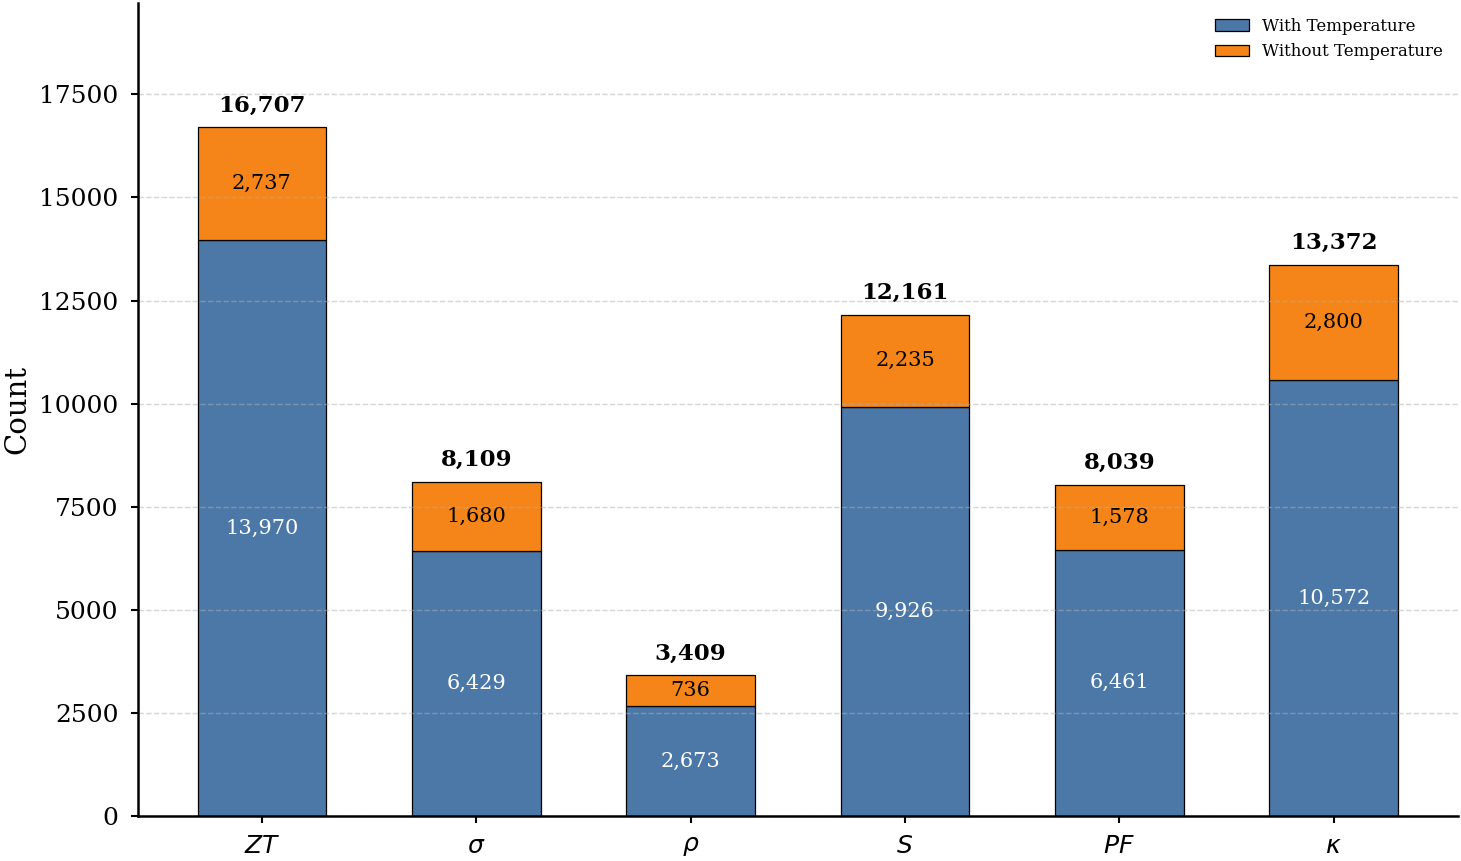

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Style (no external LaTeX needed)
rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times", "Computer Modern Roman"],
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.linewidth": 1.2,
    "figure.dpi": 150,
    "axes.unicode_minus": False,
})

# symbols_present must match the order of df_temp_stats rows
symbols_present = [r"$ZT$", r"$\sigma$", r"$\rho$", r"$S$", r"$PF$", r"$\kappa$"]
symbols_present = symbols_present[:len(df_temp_stats)]  # guard length

# Data arrays (in the same order as df_temp_stats)
w = df_temp_stats["with_temperature"].to_numpy(dtype=float)
wo = df_temp_stats["without_temperature"].to_numpy(dtype=float)
tot = w + wo
x = np.arange(len(df_temp_stats))
width = 0.6

# Colors
c_with = "#4C78A8"   # blue
c_without = "#F58518" # orange

fig, ax = plt.subplots(figsize=(10, 6))

# Draw stacked bars MANUALLY so we control positions
bars_with = ax.bar(x, w, width, color=c_with, edgecolor="black", linewidth=0.6, label="With Temperature")
bars_wo   = ax.bar(x, wo, width, bottom=w, color=c_without, edgecolor="black", linewidth=0.6, label="Without Temperature")

# Axes labels / ticks
ax.set_ylabel("Count")
#ax.set_title("Thermoelectric Property Values: With and Without Temperature", fontweight="bold")
ax.set_xlabel("")
ax.set_xticks(x)
ax.set_xticklabels(symbols_present, rotation=0)

# Grid & spines
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
for side in ["left", "bottom"]:
    ax.spines[side].set_linewidth(1.2)
ax.grid(True, axis="y", linestyle="--", linewidth=0.7, alpha=0.5)
ax.grid(False, axis="x")

# Label thresholds to avoid clutter on tiny segments
max_total = float(tot.max()) if len(tot) else 1.0
seg_thresh = max(5, 0.02 * max_total)   # hide segment labels if segment < ~2% of max
total_offset = np.maximum(1, 0.015 * max_total)  # lift total labels above stacks

# Add labels: segment counts (centered) + total on top
for i, (b1, b2) in enumerate(zip(bars_with, bars_wo)):
    h1 = b1.get_height()
    h2 = b2.get_height()
    y1 = b1.get_y() + h1 / 2.0                  # center of bottom segment
    y2 = b2.get_y() + h2 / 2.0                  # center of top segment (uses true bottom=w[i])
    # Segment labels
    if h1 >= seg_thresh:
        ax.text(b1.get_x() + b1.get_width()/2.0, y1,
                f"{int(w[i]):,}", ha="center", va="center", fontsize=10, color="white")
    if h2 >= seg_thresh:
        ax.text(b2.get_x() + b2.get_width()/2.0, y2,
                f"{int(wo[i]):,}", ha="center", va="center", fontsize=10, color="black")
    # Total label (bold, above the stack)
    ax.text(b2.get_x() + b2.get_width()/2.0, w[i] + wo[i] + total_offset,
            f"{int(tot[i]):,}", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Give headroom for top labels
ax.set_ylim(0, max_total * 1.18)

ax.legend(frameon=False)
plt.tight_layout()

# Save at 600 dpi PNG + vector PDF
outdir = "/content"  # change if not on Colab
os.makedirs(outdir, exist_ok=True)
plt.savefig(os.path.join(outdir, "temp_coverage_bar_plot.png"), dpi=800, bbox_inches="tight")
plt.savefig(os.path.join(outdir, "temp_coverage_bar_plot.pdf"), bbox_inches="tight")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import ast
import re
from typing import Any, Dict, List, Tuple

# Choose material column
mat_col = "material_name" if "material_name" in df.columns else "name"

# ====== Helpers (work directly from raw columns) ======
def _parse_obj(x):
    if isinstance(x, (list, dict)) or pd.isna(x):
        return x
    s = str(x).strip()
    if s in ("", "None", "[]", "{}", "nan"):
        return np.nan
    try:
        return ast.literal_eval(s)
    except Exception:
        return x  # scalar string/number

def _to_num(x):
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return None
        if isinstance(x, (int, float, np.integer, np.floating)):
            return float(x)
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', str(x))
        return float(m.group(0)) if m else None
    except Exception:
        return None

def _pick_first(d: dict, keys: List[str]):
    for k in keys:
        if k in d and d[k] is not None and str(d[k]).strip() not in ("", "None", "nan"):
            return d[k]
    return None

def _collect_pairs_with_units(list_like, value_keys: List[str], temp_keys: List[str],
                              unit_keys: List[str], temp_unit_keys: List[str]) -> List[Tuple[Any, Any, Any, Any]]:
    """
    From list/dict/scalar -> list of (value, temp, value_unit, temp_unit from data).
    - Converts temperature unit °C -> K (adds 273.15) and sets temp_unit to 'K'
    - If temperature exists but no unit -> default to 'K'
    - Leaves ZT (dimensionless) value_unit as None if not present
    """
    out = []
    obj = _parse_obj(list_like)

    def _one(d):
        val = _pick_first(d, value_keys + ["value"])
        vnum = _to_num(val)

        # temperature + unit
        T_raw = _pick_first(d, temp_keys)
        T = _to_num(T_raw)

        vunit = _pick_first(d, unit_keys)
        tunit = _pick_first(d, temp_unit_keys)

        # normalize temperature units
        if T is not None:
            if isinstance(tunit, str) and ("°C" in tunit or tunit.strip().lower() in ["c", "degc"]):
                # convert °C -> K
                T = T + 273.15
                tunit = "K"
            elif tunit is None or str(tunit).strip() in ("", "None", "nan"):
                # default K if temp exists and unit missing
                tunit = "K"

        out.append((vnum if vnum is not None else val, T, vunit, tunit))

    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict):
                _one(item)
            else:
                out.append((item, None, None, None))
    elif isinstance(obj, dict):
        _one(obj)
    elif pd.notna(obj):
        # scalar cell (no dict), no unit info
        out.append((_to_num(obj), None, None, None))

    return out

def _fmt_pairs_units(pairs):
    """
    Format list of (value, temp, vunit, tunit) into 'value [vunit]@T[tunit]' strings joined by ' | '.
    - Keeps units from data (no hardcoded suffixes)
    """
    bits = []
    for v, t, vunit, tunit in pairs:
        # value text
        if isinstance(v, (int, float)) and v is not None:
            vtxt = f"{v:.3g}"
        elif v is None or (isinstance(v, float) and np.isnan(v)):
            vtxt = "—"
        else:
            vtxt = str(v)

        # attach value unit if present
        if vunit is not None and str(vunit).strip():
            vtxt = f"{vtxt} {str(vunit).strip()}"

        # temperature
        if t is not None:
            Ttxt = f"{_to_num(t):.0f}"
            if tunit is not None and str(tunit).strip():
                Ttxt = f"{Ttxt}{str(tunit).strip()}"
            else:
                # if somehow missing here, default to K
                Ttxt = f"{Ttxt}K"
            bits.append(f"{vtxt}@{Ttxt}")
        else:
            bits.append(vtxt)

    return " | ".join(bits)

def _collapse_unique_text(cell):
    obj = _parse_obj(cell)
    vals = []
    if isinstance(obj, list):
        for x in obj:
            if isinstance(x, dict):
                vals.extend([f"{k}={v}" for k,v in x.items()])
            elif pd.notna(x):
                vals.append(str(x))
    elif isinstance(obj, dict):
        vals.extend([f"{k}={v}" for k,v in obj.items()])
    elif pd.notna(obj):
        vals.append(str(obj))
    # unique preserve order
    seen, uniq = set(), []
    for x in vals:
        if x not in seen:
            seen.add(x); uniq.append(x)
    return " | ".join(uniq)

# ====== Spec for raw columns (NOW WITH UNIT KEYS) ======
spec = {
    "ZT": dict(
        col="ZT_values",
        vkeys=["ZT_value","value"],
        tkeys=["ZT_temperature","temperature","Temperature","T"],
        ukeys=["ZT_unit","unit","Unit"],              # value units (usually none) — kept if present
        tukeys=["ZT_temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "S":  dict(
        col="seebeck_coefficient",
        vkeys=["S_value","value"],
        tkeys=["S_Temperature","Temperature","T","temp"],
        ukeys=["S_unit","unit","Unit"],
        tukeys=["S_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "k":  dict(
        col="thermal_conductivity",
        vkeys=["κ_value","k_value","value"],
        tkeys=["κ_Temperature","Temperature","T"],
        ukeys=["κ_unit","k_unit","unit","Unit"],
        tukeys=["κ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "σ":  dict(
        col="electrical_conductivity",
        vkeys=["σ_value","sigma_value","value"],
        tkeys=["σ_Temperature","Temperature","T"],
        ukeys=["σ_unit","sigma_unit","unit","Unit"],
        tukeys=["σ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "PF": dict(
        col="power_factor",
        vkeys=["PF_value","value"],
        tkeys=["PF_Temperature","Temperature","T"],
        ukeys=["PF_unit","unit","Unit"],
        tukeys=["PF_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "ρ":  dict(
        col="electrical_resistivity",
        vkeys=["ρ_value","rho_value","value"],
        tkeys=["ρ_Temperature","Temperature","T"],
        ukeys=["ρ_unit","rho_unit","unit","Unit"],
        tukeys=["ρ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
}

struct_fields = [
    "compound_type", "crystal_structure", "lattice_structure", "unit",
    "space_group", "processing_method",
    "lattice_parameters.a", "lattice_parameters.b", "lattice_parameters.c",
    "doping.doping_type", "doping.dopants"
]
struct_fields = [f for f in struct_fields if f in df.columns]

# ====== Build one-row-per (doi, material) table ======
base = df[["doi_key", mat_col] + struct_fields].copy().rename(columns={mat_col: "material"})
base = base.drop_duplicates(subset=["doi_key","material"])

# Prepare lookups for each metric (carrying units from data)
for label, cfg in spec.items():
    col = cfg["col"]
    if col not in df.columns:
        base[label] = ""
        continue
    pairs_map: Dict[Tuple[str,str], List[Tuple[Any,Any,Any,Any]]] = {}
    for (doi, mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        all_pairs = []
        for cell in sub[col].tolist():
            all_pairs.extend(
                _collect_pairs_with_units(
                    cell, cfg["vkeys"], cfg["tkeys"], cfg["ukeys"], cfg["tukeys"]
                )
            )
        # keep only pairs that have at least a value
        cleaned = []
        for v, T, vu, tu in all_pairs:
            if (v is None) or (isinstance(v, float) and np.isnan(v)):
                continue
            cleaned.append((v, T, vu, tu))
        pairs_map[(doi, mat)] = cleaned

    # format using units from data (no hardcoded suffixes)
    base[label] = [
        _fmt_pairs_units(pairs_map.get((r.doi_key, r.material), []))
        for r in base.itertuples()
    ]

# Collapse structural fields per (doi, material)
for sf in struct_fields:
    collapsed = {}
    for (doi, mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        vals = sub[sf] if sf in sub.columns else pd.Series([], dtype=object)
        text = " | ".join([t for t in {_collapse_unique_text(v) for v in vals} if t])
        collapsed[(doi, mat)] = text
    base[sf] = [collapsed.get((r.doi_key, r.material), "") for r in base.itertuples()]

# Filter out rows with no metrics at all (optional; comment to keep everything)
metric_cols = list(spec.keys())
mask_any_metric = base[metric_cols].apply(lambda s: s.astype(str).str.strip() != "", axis=0).any(axis=1)
base = base[mask_any_metric].copy()

# Nice ordering
ordered = ["doi_key", "material"] + metric_cols + struct_fields
base = base[ordered].sort_values(["doi_key","material"], kind="stable")

# Save and show a small preview (showcase file)
out_csv = "doi_material_rowwise_table_units_from_data_showcase.csv"
base.to_csv(out_csv, index=False)
out_csv


'doi_material_rowwise_table_units_from_data_showcase.csv'

In [ ]:
import pandas as pd
import numpy as np
import ast
import re
from typing import Any, Dict, List, Tuple

# =========================
# Toggle: use canonical units or original ones from data
# =========================
USE_CANONICAL_UNITS = True   # <- set False to show original units instead

# =========================
# Canonical unit spec
# =========================
CANON_TARGET = {
    "ZT": "",
    "S":  "μV/K",
    "σ":  "S/m",
    "ρ":  "Ω·m",
    "k":  "W/mK",
    "PF": "W/mK²",
}

# -------------------------
#  normalize_value
# -------------------------
def _clean_unit(u):
    if u is None: return ""
    s = str(u).strip()
    s = s.replace("µ","μ")
    s = re.sub(r'(^|[^A-Za-z])u(V|W)', r'\1μ\2', s)
    s = s.replace(" ", "").replace("·","").replace("*","").replace("^","")
    s = s.replace("^-1","-1").replace("/K","K").replace("K^2","K2").replace("mK^2","mK2")
    s = s.replace("cm-1","cm^-1").replace("m-1","m^-1")
    s = s.replace("Ω-1","Ω^-1").replace("ohm","Ω").replace("Ohm","Ω")
    return s.lower()

def normalize_value(label: str, val, unit_raw):
    """Return (value_in_canonical, canonical_unit) for label in {'S','σ','ρ','k','PF','ZT'}."""
    tgt = CANON_TARGET[label]
    if label == "ZT":
        try: return float(val), ""
        except: return None, ""
    u = _clean_unit(unit_raw) if unit_raw not in (None,"","None","nan") else ""
    try:
        v = float(val)
    except:
        return None, tgt

    if label == "S":  # -> μV/K
        if u in ("μv/k","μvk","microv/k","microvk","μvperk"): f=1.0
        elif u in ("mv/k","mvk"): f=1e3
        elif u in ("v/k","vk"): f=1e6
        else: f=1.0
        return v*f, tgt

    if label == "σ":  # -> S/m
        if u in ("s/m","sm-1"): f=1.0
        elif u in ("s/cm","scm-1","Ω^-1cm^-1","ω^-1cm^-1","ohm^-1cm^-1"): f=100.0
        else: f=1.0
        return v*f, tgt

    if label == "ρ":  # -> Ω·m
        if u in ("Ωm","ωm","ohmm"): f=1.0
        elif u in ("Ωcm","ωcm","ohmcm"): f=0.01
        elif u in ("mΩcm","mωcm","mohmcm","mΩcm","mΩ·cm".lower()): f=1e-5
        else: f=1.0
        return v*f, tgt

    if label == "k":  # -> W/mK
        if u in ("w/mk","wm-1k-1","w/(mk)"): f=1.0
        elif u in ("mw/cmk","mwcm-1k-1"): f=0.1
        else: f=1.0
        return v*f, tgt

    if label == "PF":  # -> W/mK²
        if u in ("w/mk2","w/mk²","wm-1k-2"): f=1.0
        elif u in ("μw/cmk2","μwcm-1k-2"): f=1e-4
        elif u in ("mw/mk2","mw/mk²"): f=1e-3
        else: f=1.0
        return v*f, tgt

    return v, tgt

# =========================
# Parsing helpers
# =========================
def _parse_obj(x):
    if isinstance(x,(list,dict)) or pd.isna(x):
        return x
    s = str(x).strip()
    if s in ("","None","[]","{}","nan"):
        return np.nan
    try:
        return ast.literal_eval(s)
    except Exception:
        return x

def _to_num(x):
    try:
        if x is None or (isinstance(x,float) and np.isnan(x)): return None
        if isinstance(x,(int,float,np.integer,np.floating)): return float(x)
        m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', str(x))
        return float(m.group(0)) if m else None
    except Exception:
        return None

def _pick_first(d: dict, keys: List[str]):
    for k in keys:
        if k in d and d[k] is not None and str(d[k]).strip() not in ("","None","nan"):
            return d[k]
    return None

# now returns (value, tempK, value_unit_raw, temp_unit_out)
def _collect_pairs_full(list_like, value_keys, temp_keys, unit_keys, temp_unit_keys):
    out=[]
    obj=_parse_obj(list_like)

    def _one(d):
        val = _pick_first(d, value_keys+["value"])
        vnum = _to_num(val)
        vunit = _pick_first(d, unit_keys)

        T_raw = _pick_first(d, temp_keys)
        T = _to_num(T_raw)
        tunit = _pick_first(d, temp_unit_keys)
        # temp unit normalize: °C -> K; missing -> K if T present
        if T is not None:
            if isinstance(tunit,str) and ("°C" in tunit or tunit.strip().lower() in ["c","degc"]):
                T = T + 273.15
                tunit = "K"
            elif tunit is None or str(tunit).strip() in ("","None","nan"):
                tunit = "K"
        out.append((vnum if vnum is not None else val, T, vunit, tunit))

    if isinstance(obj,list):
        for it in obj:
            if isinstance(it,dict): _one(it)
            else: out.append((it,None,None,None))
    elif isinstance(obj,dict):
        _one(obj)
    elif pd.notna(obj):
        out.append((_to_num(obj),None,None,None))
    return out

def _fmt_pairs_display(pairs, label):
    """
    Format list of (value, tempK, value_unit, temp_unit) into 'value unit@Tunit'.
    If USE_CANONICAL_UNITS=True -> convert value & show canonical unit; else show raw unit.
    """
    bits=[]
    for v, t, vunit_raw, tunit in pairs:
        # pick display value & unit
        if USE_CANONICAL_UNITS:
            v_std, u_std = normalize_value(label, v, vunit_raw)
            v_disp = v_std
            unit_disp = u_std
        else:
            v_disp = v
            unit_disp = (str(vunit_raw).strip() if vunit_raw is not None else "")
        # value text
        if isinstance(v_disp,(int,float)) and v_disp is not None:
            vtxt = f"{float(v_disp):.3g}"
        elif v_disp is None or (isinstance(v_disp,float) and np.isnan(v_disp)):
            vtxt = "—"
        else:
            vtxt = str(v_disp)
        if unit_disp:
            vtxt = f"{vtxt} {unit_disp}"
        # temp
        if t is not None:
            Ttxt = f"{_to_num(t):.0f}{tunit if tunit else 'K'}"
            bits.append(f"{vtxt}@{Ttxt}")
        else:
            bits.append(vtxt)
    return " | ".join(bits)

# =========================
# Column spec (raw columns + keys)
# =========================
spec = {
    "ZT": dict(
        col="ZT_values",
        vkeys=["ZT_value","value"],
        tkeys=["ZT_temperature","temperature","Temperature","T"],
        ukeys=["ZT_unit","unit","Unit"],
        tukeys=["ZT_temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "S":  dict(
        col="seebeck_coefficient",
        vkeys=["S_value","value"],
        tkeys=["S_Temperature","Temperature","T","temp"],
        ukeys=["S_unit","unit","Unit"],
        tukeys=["S_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "k":  dict(
        col="thermal_conductivity",
        vkeys=["κ_value","k_value","value"],
        tkeys=["κ_Temperature","Temperature","T"],
        ukeys=["κ_unit","k_unit","unit","Unit"],
        tukeys=["κ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "σ":  dict(
        col="electrical_conductivity",
        vkeys=["σ_value","sigma_value","value"],
        tkeys=["σ_Temperature","Temperature","T"],
        ukeys=["σ_unit","sigma_unit","unit","Unit"],
        tukeys=["σ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "PF": dict(
        col="power_factor",
        vkeys=["PF_value","value"],
        tkeys=["PF_Temperature","Temperature","T"],
        ukeys=["PF_unit","unit","Unit"],
        tukeys=["PF_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
    "ρ":  dict(
        col="electrical_resistivity",
        vkeys=["ρ_value","rho_value","value"],
        tkeys=["ρ_Temperature","Temperature","T"],
        ukeys=["ρ_unit","rho_unit","unit","Unit"],
        tukeys=["ρ_Temperature_unit","Temperature_unit","T_unit","unit_T"]
    ),
}

# =========================
# Build the row-wise table with units handled
# =========================
mat_col = "material_name" if "material_name" in df.columns else ("name" if "name" in df.columns else None)
struct_fields = [
    "compound_type","crystal_structure","lattice_structure","unit",
    "space_group","processing_method",
    "lattice_parameters.a","lattice_parameters.b","lattice_parameters.c",
    "doping.doping_type","doping.dopants"
]
struct_fields = [f for f in struct_fields if f in df.columns]

base = df[["doi_key", mat_col] + struct_fields].copy().rename(columns={mat_col:"material"})
base = base.drop_duplicates(subset=["doi_key","material"])

for label, cfg in spec.items():
    col = cfg["col"]
    if col not in df.columns:
        base[label] = ""
        continue
    pairs_map={}
    for (doi, mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        all_pairs=[]
        for cell in sub[col].tolist():
            all_pairs.extend(
                _collect_pairs_full(cell, cfg["vkeys"], cfg["tkeys"], cfg["ukeys"], cfg["tukeys"])
            )
        # keep only pairs with a value
        cleaned=[p for p in all_pairs if not (p[0] is None or (isinstance(p[0],float) and np.isnan(p[0])))]
        pairs_map[(doi,mat)] = cleaned

    base[label] = [
        _fmt_pairs_display(pairs_map.get((r.doi_key, r.material), []), label)
        for r in base.itertuples()
    ]

# Collapse structural fields
def _collapse_unique_text(cell):
    obj = _parse_obj(cell)
    vals=[]
    if isinstance(obj,list):
        for x in obj:
            if isinstance(x,dict): vals.extend([f"{k}={v}" for k,v in x.items()])
            elif pd.notna(x): vals.append(str(x))
    elif isinstance(obj,dict):
        vals.extend([f"{k}={v}" for k,v in obj.items()])
    elif pd.notna(obj):
        vals.append(str(obj))
    seen, uniq=set(), []
    for x in vals:
        if x not in seen:
            seen.add(x); uniq.append(x)
    return " | ".join(uniq)

for sf in struct_fields:
    collapsed={}
    for (doi,mat), sub in df.groupby(["doi_key", mat_col], dropna=False):
        vals = sub[sf] if sf in sub.columns else pd.Series([], dtype=object)
        text = " | ".join([t for t in {_collapse_unique_text(v) for v in vals} if t])
        collapsed[(doi,mat)] = text
    base[sf] = [collapsed.get((r.doi_key, r.material), "") for r in base.itertuples()]

# Filter out rows with no metrics
metric_cols = list(spec.keys())
mask_any_metric = base[metric_cols].apply(lambda s: s.astype(str).str.strip() != "", axis=0).any(axis=1)
base = base[mask_any_metric].copy()

ordered = ["doi_key","material"] + metric_cols + struct_fields
base = base[ordered].sort_values(["doi_key","material"], kind="stable")

# Save
out_csv = "doi_material_rowwise_table_CANON.csv" if USE_CANONICAL_UNITS else "doi_material_rowwise_table_ORIGINAL_UNITS.csv"
base.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: doi_material_rowwise_table_CANON.csv
